In [50]:
from lemminflect import getLemma
import spacy, os

en_spacy = spacy.load("en_core_web_sm")

sent = "new batteries were already dead"

for word in en_spacy(sent):
    print(word.tag_)
    if word.tag_ == "VBD" or word.tag_ == "VBN" or word.tag_ == "MD":
        print(getLemma(word.text, upos="VERB"))

JJ
NNS
VBD
('be',)
RB
JJ


In [47]:
from lemminflect import getLemma
import spacy, os

en_spacy = spacy.load("en_core_web_sm")

input_folder = ""
output_folder = ""

for file in os.listdir(input_folder):
    with open(os.path.join(output_folder, file), "w") as out_f:
        with open(os.path.join(input_folder, file), "r") as in_f:
            for line in in_f:
                word_list = []
                try:
                    for token in en_spacy(line.strip()):
                        if token.tag_ == "VBD" or \
                            token.tag_ == "VBN" or \
                            token.tag_ == "MD":
                            word_list.append(getLemma(word.text, upos="VERB"))
                        else:
                            word_list.append(token.text)
                except:
                    continue
            
            out_f.write(" ".join(word_list)+"\n")

DT
NN
NN
NN
VBD
('have',)
VBN
('fall',)
RP


# Experiment with LemmInflect, converting word into base form.

In [12]:
wandb.finish()

eval/loss,█▂▃▃▁
eval/runtime,▄▁█▅▄
eval/samples_per_second,▅█▁▄▅
eval/steps_per_second,▅█▁▄▅
train/epoch,▁▁▃▃▅▅▆▆███
train/global_step,▁▁▃▃▅▅▆▆███
train/learning_rate,█▆▅▃▁
train/loss,█▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


In [11]:
trainer.train()

/home/saurabh/venvs/general_env/lib/python3.6/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 2 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
***** Running training *****
  Num examples = 174394
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 27250
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
/home/saurabh/venvs/general_env/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; w

Epoch,Training Loss,Validation Loss
1,0.336300,0.113553
2,0.095500,0.114488
3,0.089900,0.113921
4,0.087000,0.116483
5,0.085000,0.112458


***** Running Evaluation *****
  Num examples = 19725
  Batch size = 32
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/home/saurabh/venvs/general_env/lib/python3.6/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 2 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
***** Running Evaluation *****
  Num examples = 19725
  Batch size = 32
Saving model checkpoint to /data3/saurabh/Product-Comparison/exper

TrainOutput(global_step=27250, training_loss=0.1387366372204702, metrics={'train_runtime': 36338.0377, 'train_samples_per_second': 23.996, 'train_steps_per_second': 0.75, 'total_flos': 1.431311706316206e+17, 'train_loss': 0.1387366372204702, 'epoch': 5.0})

In [10]:
trainer = Seq2SeqTrainer(model = encoder_decoder_model,
     tokenizer = tokenizer,
    train_dataset = train_dataset,
    args = training_args,
    eval_dataset = val_dataset)

In [9]:
training_args = Seq2SeqTrainingArguments(
    output_dir = output_dir,
    do_train = True,
    do_eval = True,
    evaluation_strategy = "epoch",
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    num_train_epochs = 5,
    logging_dir = log_dir,
    logging_strategy = "epoch",
    save_strategy = "epoch",
    save_total_limit = 5,
    run_name = run_name,
    report_to = "wandb")

torch.cuda.device_count(): 4


In [8]:
train_dataset = ComparativeResponseDataset(train_input_encoding, train_output_encoding)
val_dataset = ComparativeResponseDataset(val_input_encoding, val_output_encoding)

In [7]:
%%time

train_input, train_output = read_jsonl(train_file)
val_input, val_output = read_jsonl(val_file)

train_input_encoding = tokenizer(train_input, truncation=True, padding=True)
train_output_encoding = tokenizer(train_output, truncation=True, padding=True)
val_input_encoding = tokenizer(val_input, truncation=True, padding=True) 
val_output_encoding = tokenizer(val_output, truncation=True, padding=True)

CPU times: user 2min 29s, sys: 1.16 s, total: 2min 30s
Wall time: 2min 30s


In [6]:
class ComparativeResponseDataset(torch.utils.data.Dataset):
    
    def __init__(self, input_encoding, output_encoding):
        self.input_encoding = input_encoding
        self.output_encoding = output_encoding
        
    def __getitem__(self, index):
        item = {}
        item["input_ids"] = np.array(self.input_encoding.input_ids[index])
        item["attention_mask"] = np.array(self.input_encoding.attention_mask[index])
        item["token_type_ids"] = np.array(self.input_encoding.token_type_ids[index])
        item["decoder_input_ids"] = np.array(self.output_encoding.input_ids[index])
        item["decoder_attention_mask"] = np.array(self.output_encoding.attention_mask[index])
        item["decoder_token_type_ids"] = np.array(self.output_encoding.token_type_ids[index])
        item["labels"] = []
        
        for token in self.output_encoding.input_ids[index]:
            if token == tokenizer.pad_token_id:
                item["labels"].append(-100)
            else:
                item["labels"].append(token)

        item["labels"] = np.array(item["labels"])
                
        return item
    
    def __len__(self):
        return len(self.input_encoding.input_ids)

In [5]:
def read_jsonl(file_name):
        input_data = []
        output_data = []

        with open(file_name, "r") as in_f:
            for line in in_f:
                tmp_dict = json.loads(line)
                input_data.append(tmp_dict["input"])
                output_data.append(tmp_dict["gt_output"])

        return input_data, output_data

In [4]:
tokenizer = BertTokenizer.from_pretrained(tokenizer_model, cache_dir=cache_dir)
encoder_decoder_model = EncoderDecoderModel.from_encoder_decoder_pretrained(encoder_model, decoder_model, cache_dir=cache_dir)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.weight', 'cls.seq_relatio

In [3]:
train_file = "/data3/saurabh/Product-Comparison/experiments/run9/dataset/train.jsonl"
val_file = "/data3/saurabh/Product-Comparison/experiments/run9/dataset/val.jsonl"
output_dir = "/data3/saurabh/Product-Comparison/experiments/run9/output"
log_dir = "/data3/saurabh/Product-Comparison/experiments/run9/logs"
cache_dir = "/data3/saurabh/Product-Comparison/experiments/run9/cache"
run_name = "bert2bert_encoder_decoder_amazon_v6"
tokenizer_model = "bert-base-uncased"
encoder_model = "bert-base-uncased"
decoder_model = "bert-base-uncased"

In [2]:
wandb.login()

os.environ["WANDB_PROJECT"] = "comparitive_response_generation"

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"
wandb.init(dir="/data3/saurabh/Product-Comparison/experiments/run9/wandb")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: saurabhhssaurabh (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [1]:
from transformers import BertTokenizer, EncoderDecoderModel, Seq2SeqTrainer, Seq2SeqTrainingArguments
import json, torch, wandb, os, random
import numpy as np

# Train encoder decoder model on hand curated V4 dataset / v5_dataset(run8)

In [121]:
with open(output_file, "w") as out_f:
    with open(input_file, "r") as in_f:
        for line in in_f:
            tmp_dict = json.loads(line)

            input_list = tmp_dict["input"].split(".")

            pos_list = input_list[1].strip().split(" ")
            neg_list = input_list[2].strip().split(" ")
            new_title = " ".join(input_list[0].strip().split(" ")[:2])

            if pos_list[0] == "it" or neg_list[0] == "it":
                if pos_list[0] == "it":
                    pos_list[0] = new_title

                new_pos = " ".join(pos_list)

                if neg_list[0] == "it":
                    neg_list[0] = new_title

                new_neg = " ".join(neg_list)

                new_input = "{} . {} . {} .".format(new_title, new_pos, new_neg)
                tmp_dict["input"] = new_input
                
                gt_output_list = tmp_dict["gt_output"].split(".")
                gt_output_list[0] = new_title
                tmp_dict["gt_output"] = "{} . {} . {} .".format(gt_output_list[0], gt_output_list[1], gt_output_list[2])

                out_f.write(json.dumps(tmp_dict) + "\n")            

In [120]:
input_file = "/data3/saurabh/experiments/run2/dataset/test.jsonl"
output_file = "/data3/saurabh/experiments/run2/dataset/coref_test.jsonl"

# Generate dataset to test coreference resolution

In [102]:
stat_dict

{'8_9': {'however , there are people who have complained that': 15,
  'on the other hand few users have complained that': 172},
 '7_8': {'however': 389,
  'but ,': 99,
  'on the other hand ,': 738,
  'on the other hand few users have complained that': 559,
  'yet , some users have also mentioned that': 716,
  'however , there are people who have complained that': 725},
 '6_7': {', according to few users': 12, 'but ,': 660, 'however': 166},
 '5_6': {'however': 113, ', according to few users': 756},
 '4_5': {'however': 57}}

In [101]:
line_num = 0

with open(input_file, "r") as in_f:
    for line in in_f:
        line_num += 1
        tmp_dict = json.loads(line)
        
        try:
        
            if tmp_dict["sari"]["sari_score"] >= 0.80:
                if tmp_dict["connecting_string"] in stat_dict["8_9"]:
                    stat_dict["8_9"][tmp_dict["connecting_string"]] += 1
                else:
                    stat_dict["8_9"][tmp_dict["connecting_string"]] = 1
            elif tmp_dict["sari"]["sari_score"] >= 0.70:
                if tmp_dict["connecting_string"] in stat_dict["7_8"]:
                    stat_dict["7_8"][tmp_dict["connecting_string"]] += 1
                else:
                    stat_dict["7_8"][tmp_dict["connecting_string"]] = 1
            elif tmp_dict["sari"]["sari_score"] >= 0.60:
                if tmp_dict["connecting_string"] in stat_dict["6_7"]:
                    stat_dict["6_7"][tmp_dict["connecting_string"]] += 1
                else:
                    stat_dict["6_7"][tmp_dict["connecting_string"]] = 1
            elif tmp_dict["sari"]["sari_score"] >= 0.50:
                if tmp_dict["connecting_string"] in stat_dict["5_6"]:
                    stat_dict["5_6"][tmp_dict["connecting_string"]] += 1
                else:
                    stat_dict["5_6"][tmp_dict["connecting_string"]] = 1
            elif tmp_dict["sari"]["sari_score"] >= 0.40:
                if tmp_dict["connecting_string"] in stat_dict["4_5"]:
                    stat_dict["4_5"][tmp_dict["connecting_string"]] += 1
                else:
                    stat_dict["4_5"][tmp_dict["connecting_string"]] = 1
        except:
            print(line_num)

In [100]:
stat_dict = {}
stat_dict["8_9"] = {}
stat_dict["7_8"] = {}
stat_dict["6_7"] = {}
stat_dict["5_6"] = {}
stat_dict["4_5"] = {}

In [99]:
input_file = "/data3/saurabh/experiments/run2/stat.jsonl"

In [98]:
with open(stat_file, "w") as out_f:
    for elem in sorted_output_list:
        out_f.write(json.dumps(elem)+"\n")

In [97]:
sorted_output_list = sorted(output_list, key=lambda x: x["sari"]["sari_score"])
print(len(sorted_output_list))

5177


In [96]:
output_list = []

for instance_index in range(len(instance_list)):
    tmp_dict = instance_list[instance_index].copy()
    output = SARIsent(instance_list[instance_index]["input"], instance_list[instance_index]["pred_output"],
                      instance_list[instance_index]["gt_references"])
    tmp_dict["sari"] = {}
    tmp_dict["sari"]["sari_score"] = output[0]
    tmp_dict["sari"]["keep_score"] = output[1]
    tmp_dict["sari"]["add_score"] = output[2]
    tmp_dict["sari"]["del_score"] = output[3]

    for index in range(len(pattern_list)):
        if pattern_list[index] in test_instance_list[instance_index]["gt_output"]:
            tmp_dict["connecting_string"] = pattern_list[index]
            break

    output_list.append(tmp_dict)

In [95]:
pattern_1 = "however , there are people who have complained that"
pattern_2 = "but ,"
pattern_3 = "on the other hand ,"
pattern_4 = "however"
pattern_5 = "yet , some users have also mentioned that"
pattern_6 = ", according to few users"
pattern_7 = "on the other hand few users have complained that"

# pattern_1 = ". however , there are people who have complained that"
# pattern_2 = ". but ,"
# pattern_3 = ". on the other hand ,"
# pattern_4 = ". however"
# pattern_5 = ". yet , some users have also mentioned that"
# pattern_6 = ", according to few users"
# pattern_7 = ". on the other hand few users have complained that"

pattern_list = [pattern_1, pattern_2, pattern_3, pattern_4, pattern_5, pattern_6, pattern_7]

In [34]:
# with open(stat_file, "w") as out_f:
#     for instance in instance_list:
#         tmp_dict = instance.copy()
#         output = SARIsent(instance["input"], instance["pred_output"], instance["gt_references"])
#         tmp_dict["sari"] = {}
#         tmp_dict["sari"]["sari_score"] = output[0]
#         tmp_dict["sari"]["keep_score"] = output[1]
#         tmp_dict["sari"]["add_score"] = output[2]
#         tmp_dict["sari"]["del_score"] = output[3]
        
#         tmp_dict["sari_ref"] = []
        
#         for ref in instance["gt_references"]:
#             tmp_dict_1 = {}
#             output = SARIsent(instance["input"], instance["pred_output"], [ref])
#             tmp_dict_1["sent"] = ref
#             tmp_dict_1["sari_score"] = output[0]
#             tmp_dict_1["keep_score"] = output[1]
#             tmp_dict_1["add_score"] = output[2]
#             tmp_dict_1["del_score"] = output[3]
            
#             tmp_dict["sari_ref"].append(tmp_dict_1)
            
#         out_f.write(json.dumps(tmp_dict)+"\n")

In [85]:
len(test_instance_list)

5177

In [83]:
instance_list = []

with open(input_file, "r") as in_f:
    for line in in_f:
        instance_list.append(json.loads(line))
        
test_instance_list = []

with open(test_file, "r") as in_f:
    for line in in_f:
        test_instance_list.append(json.loads(line))

In [82]:
input_file = "/data3/saurabh/experiments/run2/pred_output.jsonl"
test_file = "/data3/saurabh/experiments/run2/dataset/test.jsonl"
stat_file = "/data3/saurabh/experiments/run2/stat.jsonl"

In [81]:
from evaluation.sari_hugging_face import SARIsent
import json

# Evaluation on individual and all references

In [14]:
df.connective_string.unique()

array(['however ,', 'but', 'on the other hand ,', 'however', 'but ,',
       'yet ,', 'although ,', 'on the other hand'], dtype=object)

In [13]:
df.groupby(df.connective_string).agg(["count"])

,coherent_first_sentence,coherent_second_sentence,incoherent_first_sentence,incoherent_second_sentence,discourse_type,has_coref_type_pronoun,has_coref_type_nominal
,count,count,count,count,count,count,count
connective_string,,,,,,,
"although ,",1051,1051,1051,1051,1051,1051,1051
but,37088,37088,37088,37088,37088,37088,37088
"but ,",1912,1912,1912,1912,1912,1912,1912
however,37791,37791,37791,37791,37791,37791,37791
"however ,",328264,328264,328264,328264,328264,328264,328264
on the other hand,791,791,791,791,791,791,791
"on the other hand ,",6290,6290,6290,6290,6290,6290,6290
"yet ,",2073,2073,2073,2073,2073,2073,2073


In [12]:
# DiscoFuse wikipedia balance dataset analysis
input_file = "/data3/saurabh/discofuse_v1/wikipedia/train_balanced_pair_only.tsv"

df = pd.read_csv(input_file, sep="\t")

In [ ]:
Amazon dataset:

" . however , there are people who have complained that ": 13270
" . but , ": 13296
" . on the other hand , ": 13320
" . however ": 13347
" . yet , some users have also mentioned that ": 13315
" , according to few users ": 13298
" . on the other hand few users have complained that ": 13348

    
    
DiscoFuse Wiki Balance:

"yet ,": 2073
"on the other hand ,": 6290
"on the other hand": 791
"however ,": 328264
"however": 37791
"but ,": 1912
"but": 37088
"although ,": 1051
    
    
Combined:

" . however , there are people who have complained that ": 13270
" . but , ": 15208
" . on the other hand , ": 19610
" . however ": 13347
" . yet , some users have also mentioned that ": 13315
" , according to few users ": 13298
" . on the other hand few users have complained that ": 13348
"yet ,": 2073
"on the other hand": 791
"however ,": 328264
"however": 37791
"but": 37088
"although ,": 1051

In [17]:
13270 + 15208 + 19610 + 13347 + 13315 + 13298 + 13348 + 2073 + 791 + 328264 + 37791 + 37088 + 1051

508454

In [9]:
print(c1, c2, c3, c4, c5, c6, c7)

13270 13296 13320 13347 13315 13298 13348


In [10]:
c1 + c2 + c3 + c4 + c5 + c6 + c7

93194

In [7]:
c1 = c2 = c3 = c4 = c5 = c6 = c7 = 0

with open(input_file, "r") as in_f:
    for line in in_f:
        text = json.loads(line)["gt_output"]
        
        if pattern_1 in text:
            c1 += 1
        elif pattern_2 in text:
            c2 += 1
        elif pattern_3 in text:
            c3 += 1
        elif pattern_4 in text:
            c4 += 1
        elif pattern_5 in text:
            c5 += 1
        elif pattern_6 in text:
            c6 += 1
        elif pattern_7 in text:
            c7 += 1

In [2]:
input_file = "/data3/saurabh/experiments/data/14_transformer_encoder_decoder/train_amazon.jsonl"

In [6]:
pattern_1 = " . however , there are people who have complained that "
pattern_2 = " . but , "
pattern_3 = " . on the other hand , "
pattern_4 = " . however "
pattern_5 = " . yet , some users have also mentioned that "
pattern_6 = " , according to few users "
pattern_7 = " . on the other hand few users have complained that "

In [11]:
import json
import pandas as pd

# Analysis of training dataset and results.

In [176]:
sum_ = 0

for elem in sorted_sari_list_without_normalization:
    sum_ += elem[0]
    
sum_/len(sorted_sari_list_without_normalization)

0.865049843323722

In [173]:
for ref in ref_list[5136]:
    print(ref.lower())

samsung galaxy tab 3 ( 8 - inch, white ) 2013 model. it is smooth. on the other hand, the screen is useless.


In [174]:
pred_output_list[5136]

'samsung galaxy tab 3 ( 8 - inch, white ) 2013 model. it is smooth. on the other hand, the screen is useless.'

In [175]:
input_list[5136]

'samsung galaxy tab 3 ( 8 - inch, white ) 2013 model. it is smooth. the screen is useless.'

In [172]:
sorted_sari_list_without_normalization[5170]

(1.0, 5136)

In [122]:
sorted_sari_list_without_normalization = sorted(sari_list_without_normalization, key=lambda x: x[0])

In [121]:
sari_list_without_normalization = []
keep_list_without_normalization = []
add_list_without_normalization = []
del_list_without_normalization = []

for index in range(len(input_list)):
    output = SARIsent(input_list[index], pred_output_list[index], ref_list[index])
    sari_list_without_normalization.append((output[0], index))
    keep_list_without_normalization.append(output[1])
    add_list_without_normalization.append(output[2])
    del_list_without_normalization.append(output[3])

In [120]:
input_list = []
pred_output_list = []
ref_list = []

for index in range(len(pred_data)):
    input_list.append(pred_data[index]["input"])
    pred_output_list.append(pred_data[index]["pred_output"])
    ref_list.append([pred_data[index]["gt_output"]])

In [119]:
test_data = []

with open(test_file, "r") as in_f:
    for line in in_f:
        test_data.append(json.loads(line))
        
pred_data = []

with open(pred_output_file, "r") as in_f:
    for line in in_f:
        pred_data.append(json.loads(line))

In [118]:
pred_output_file = "/data3/saurabh/experiments/run2/pred_output.jsonl"
test_file = "/data3/saurabh/experiments/run2/dataset/test.jsonl"

In [117]:
import json

# SARI on Ground Truth output

In [113]:
for ref in decoded_ref_list[620]:
    print(ref.lower())

samsung galaxy tab 3 lite 7 & quot ; t110 8gb wi - fi. love the tablet and the charger. however, there are people who have complained that there is no rear camera.
samsung galaxy tab 3 lite 7 & quot ; t110 8gb wi - fi. love the tablet and the charger. but, there is no rear camera.
samsung galaxy tab 3 lite 7 & quot ; t110 8gb wi - fi. love the tablet and the charger. on the other hand, there is no rear camera.
samsung galaxy tab 3 lite 7 & quot ; t110 8gb wi - fi. love the tablet and the charger. however there is no rear camera.
samsung galaxy tab 3 lite 7 & quot ; t110 8gb wi - fi. love the tablet and the charger. yet, some users have also mentioned that there is no rear camera.
samsung galaxy tab 3 lite 7 & quot ; t110 8gb wi - fi. although love the tablet and the charger, according to few users there is no rear camera.
samsung galaxy tab 3 lite 7 & quot ; t110 8gb wi - fi. love the tablet and the charger. on the other hand few users have complained that there is no rear camera.


In [114]:
pred_output_list[620]

'samsung galaxy tab 3 lite 7 & quot ; t110 8gb wi - fi. love the tablet and the charger. however there is no rear camera.'

In [19]:
input_list[4534]

'hp chromebook 14 ( peach coral ). the colors are perfect. which is lightning fast.'

In [35]:
index = 4764


print("Input: \n{}\n".format(input_list[index]))
print("Pred Output: \n{}".format(pred_output_list[index]))


Input: 
apple ipad mini with retina display me281ll / a ( 64gb, wi - fi, white with silver ) old version. was everything. only issue is.

Pred Output: 
apple ipad mini with retina display me281ll / a ( 64gb, wi - fi, white with silver ) old version. was everything. on the other hand few users have complained that only issue is.


In [30]:
sorted_sari_list_without_normalization[-10:]

[(0.8103510678335392, 917),
 (0.8104172147911091, 2755),
 (0.8107185839284403, 427),
 (0.810833773188525, 3236),
 (0.8108944730334167, 2502),
 (0.8109290369026326, 4764),
 (0.8109778785058434, 4947),
 (0.811291735581312, 505),
 (0.8116624045084304, 5023),
 (0.8124375090341215, 4983)]

In [17]:
sum_ = 0

for elem in sorted_sari_list_without_normalization:
    sum_ += elem[0]
    
sum_/len(sorted_sari_list_without_normalization)

0.7091603852239728

In [16]:
sorted_sari_list_without_normalization = sorted(sari_list_without_normalization, key=lambda x: x[0])

In [15]:
sari_list_without_normalization = []
keep_list_without_normalization = []
add_list_without_normalization = []
del_list_without_normalization = []

for index in range(len(input_list)):
    output = SARIsent(input_list[index], pred_output_list[index], [sent for sent in decoded_ref_list[index]])
    sari_list_without_normalization.append((output[0], index))
    keep_list_without_normalization.append(output[1])
    add_list_without_normalization.append(output[2])
    del_list_without_normalization.append(output[3])

In [14]:
len(decoded_ref_list)

5177

In [13]:
decoded_ref_list = []

for list_1 in encoded_ref_list:
    tmp_list = []
    
    try:
        for ref in list_1:
            tmp_list.append(tokenizer.decode(ref["input_ids"], skip_special_tokens=True))
    except ValueError:
        print(ref)
        
    decoded_ref_list.append(tmp_list)

In [12]:
encoded_ref_list = []

for list_1 in ref_list:
    tmp_list = []
    
    for ref in list_1:
        tmp_list.append(tokenizer(ref.lower(), padding=True, truncation=True))
        
    encoded_ref_list.append(tmp_list)

In [11]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [10]:
from transformers import BertTokenizer

# Below code without normalization 

In [28]:
sum(del_list)/len(add_list)

0.9157636947672984

In [29]:
sum(sari_list)/len(sari_list)

0.7248210813067055

In [24]:
with open(stat_file, "w") as out_f:
    for elem in sorted_stat_output_list:
        out_f.write(json.dumps(elem)+"\n")

In [23]:
sorted_stat_output_list = sorted(stat_output_list, key=lambda x: x["sari"]["add_score"])

In [22]:
stat_output_list = []

for index in range(len(pred_data)):
    tmp_dict = pred_data[index].copy()
    tmp_dict["references"] = decoded_ref_list[index]
    tmp_dict["sari"] = {"sari_score": sari_list[index], "keep_score": keep_list[index], "add_score": add_list[index], 
                        "del_score": del_list[index]}
    stat_output_list.append(tmp_dict)

In [21]:
sari_list = []
keep_list = []
add_list = []
del_list = []

for index in range(len(input_list)):
    output = SARIsent(normalize(input_list[index]), normalize(pred_output_list[index]), [normalize(sent) for sent in decoded_ref_list[index]])
    sari_list.append(output[0])
    keep_list.append(output[1])
    add_list.append(output[2])
    del_list.append(output[3])

In [20]:
encoded_ref_list = []

for list_1 in ref_list:
    tmp_list = []
    
    for ref in list_1:
        tmp_list.append(tokenizer(ref.lower(), padding=True, truncation=True))
        
    encoded_ref_list.append(tmp_list)
    

decoded_ref_list = []

for list_1 in encoded_ref_list:
    tmp_list = []
    
    try:
        for ref in list_1:
            tmp_list.append(tokenizer.decode(ref["input_ids"], skip_special_tokens=True))
    except ValueError:
        print(ref)
        
    decoded_ref_list.append(tmp_list)

In [19]:
test_data = []

with open(test_file, "r") as in_f:
    for line in in_f:
        test_data.append(json.loads(line))
        
pred_data = []

with open(pred_output_file, "r") as in_f:
    for line in in_f:
        pred_data.append(json.loads(line))
        

input_list = []
pred_output_list = []
ref_list = []

for index in range(len(pred_data)):
    input_list.append(pred_data[index]["input"].lower())
    pred_output_list.append(pred_data[index]["pred_output"].lower())
    ref_list.append(test_data[index]["gt_references"])

In [18]:
pred_output_file = "/data3/saurabh/Product-Comparison/experiments/run7/pred_output.jsonl"
test_file = "/data3/saurabh/Product-Comparison/experiments/run7/dataset/test.jsonl"
stat_file = "/data3/saurabh/Product-Comparison/experiments/run7/stat.jsonl"

In [17]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /home/saurabh/.cache/huggingface/transformers/tmpxmtildjt


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt in cache at /home/saurabh/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
creating metadata file for /home/saurabh/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /home/saurabh/.cache/huggingface/transformers/tmpi6fbzvy2


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json in cache at /home/saurabh/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
creating metadata file for /home/saurabh/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
https://huggingface.co/bert-base-uncased/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /home/saurabh/.cache/huggingface/transformers/tmp52ogc16e


Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-uncased/resolve/main/tokenizer.json in cache at /home/saurabh/.cache/huggingface/transformers/534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
creating metadata file for /home/saurabh/.cache/huggingface/transformers/534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /home/saurabh/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncas

In [16]:
from evaluation.sari_hugging_face import SARIsent, normalize
import json
from transformers import BertTokenizer

# SARI from huggingface code

In [23]:
input_list_output = []
pred_output_list_output = []
ref_list_output = []

for index in range(len(pred_data)):
    input_list_output.append(pred_data[index]["input"])
    pred_output_list_output.append(pred_data[index]["pred_output"])
    ref_list_output.append([test_data[index]["gt_output"]])
    
output = sari_metric.compute(sources=input_list_output, predictions=pred_output_list_output, references=ref_list_output)
output

{'sari': 77.06148035047036}

In [21]:
output

{'sari': 65.83228673450357}

In [19]:
output = sari_metric.compute(sources=input_list, predictions=pred_output_list, references=ref_list)

In [18]:
sari_metric = datasets.load_metric("sari")

In [17]:
input_list = []
pred_output_list = []
ref_list = []

for index in range(len(pred_data)):
    input_list.append(pred_data[index]["input"])
    pred_output_list.append(pred_data[index]["pred_output"])
    ref_list.append(test_data[index]["gt_references"])

In [16]:
test_data = []

with open(test_file, "r") as in_f:
    for line in in_f:
        test_data.append(json.loads(line))
        
pred_data = []

with open(pred_output_file, "r") as in_f:
    for line in in_f:
        pred_data.append(json.loads(line))

In [15]:
pred_output_file = "/data3/saurabh/experiments/run2/pred_output.jsonl"
test_file = "/data3/saurabh/experiments/run2/dataset/test.jsonl"

In [14]:
import datasets, json

# SARI metric from datasets huggingface

In [20]:
sorted_sari_list_output = sorted(sari_list_output, key=lambda x: x[0])

In [19]:
sari_list_output = []
keep_list_output = []
addition_list_output = []
deletion_list_output = []

for index in range(len(pred_data)):
    input_ids = tokenizer(pred_data[index]["input"], padding=True, truncation=True)
    pred_ids = tokenizer(pred_data[index]["pred_output"], padding=True, truncation=True)
    ref_ids = [tokenizer(pred_data[index]["gt_output"], padding=True, truncation=True)]
            
    output_score = get_sari_score(source_ids=input_ids, prediction_ids=pred_ids, list_of_targets=ref_ids)
    sari_list_output.append((output_score[0], index))
    keep_list_output.append(output_score[1])
    addition_list_output.append(output_score[2])
    deletion_list_output.append(output_score[3])

In [33]:
sorted_sari_list[-1]

(1.0, 5176)

In [31]:
sorted_sari_list = sorted(sari_list, key=lambda x: x[0])

In [30]:
sari_list = []
keep_list = []
addition_list = []
deletion_list = []

for index in range(len(pred_data)):
    input_ids = tokenizer(pred_data[index]["input"], padding=True, truncation=True)
    pred_ids = tokenizer(pred_data[index]["pred_output"], padding=True, truncation=True)
    ref_ids = []
    
    for ref in test_data[index]["gt_references"]:
        ref_ids.append(tokenizer(ref, padding=True, truncation=True))
        
    output_score = get_sari_score(source_ids=input_ids, prediction_ids=pred_ids, list_of_targets=ref_ids)
    sari_list.append((output_score[0], index))
    keep_list.append(output_score[1])
    addition_list.append(output_score[2])
    deletion_list.append(output_score[3])

In [21]:
# pred_output_file = "/data3/saurabh/experiments/run2/pred_output.jsonl"

with open(pred_output_with_ref_file, "w") as out_f:
    for index in range(len(pred_data)):
        tmp_dict = {}
        
        tmp_dict["input"] = pred_data[index]["input"]
        tmp_dict["gt_output"] = pred_data[index]["gt_output"]
        tmp_dict["pred_output"] = pred_data[index]["pred_output"]
        
        gt_refs = test_data[index]["gt_references"]
        tmp_list = []
        
        for ref in gt_refs:
            tmp_list.append(tokenizer.decode(tokenizer(ref.lower(), truncation=True, padding=True)["input_ids"], skip_special_tokens=True))
            
        tmp_dict["gt_references"] = tmp_list
        
        out_f.write(json.dumps(tmp_dict)+"\n")

In [20]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /home/saurabh/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at /home/saurabh/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer.json from cache at /home/saurabh/.cache/huggingface/transformers/534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f41b0a70b600ca

In [19]:
test_data = []

with open(test_file, "r") as in_f:
    for line in in_f:
        test_data.append(json.loads(line))
        
pred_data = []

with open(pred_output_file, "r") as in_f:
    for line in in_f:
        pred_data.append(json.loads(line))

In [18]:
pred_output_file = "/data3/saurabh/Product-Comparison/experiments/run9/pred_output.jsonl"
test_file = "/data3/saurabh/Product-Comparison/experiments/run9/dataset/test.jsonl"
pred_output_with_ref_file = "/data3/saurabh/Product-Comparison/experiments/run9/pred_output_with_ref.jsonl"

In [15]:
from transformers import BertTokenizer
from evaluation.sari_hook import get_sari_score

import json

# Evaluation code

In [14]:
with open(pred_file, "w") as out_f:
    for index in range(len(test_preds)):
        input_ids = test_dataset[index]["input_ids"]
        output_ids = test_dataset[index]["decoder_input_ids"]
        pred_ids = test_preds[index]

        tmp_dict = id_to_text(input_ids, output_ids, pred_ids, pred_tokenizer)
        out_f.write(json.dumps(tmp_dict)+"\n")

In [13]:
def id_to_text(input_ids, output_ids, prediction_ids, tokenizer):
    
    tmp_dict = {}
    
    index_array = np.where(input_ids == 102)[0]
    if len(index_array) > 0:
        input_ids = input_ids[:index_array[0]+1]
    tmp_dict["input"] = tokenizer.decode(input_ids, skip_special_tokens=True)

    
    index_array = np.where(output_ids == 102)[0]
    if len(index_array) > 0:
        output_ids = output_ids[:index_array[0]+1]
    tmp_dict["gt_output"] = tokenizer.decode(output_ids, skip_special_tokens=True)
        
    index_array = np.where(prediction_ids == 102)[0]
    if len(index_array) > 0:
        prediction_ids = prediction_ids[:index_array[0]+1]
    tmp_dict["pred_output"] = tokenizer.decode(prediction_ids, skip_special_tokens=True)

    return tmp_dict

In [12]:
test_preds = output.predictions[0].argmax(axis=-1)
test_preds.shape

(21397, 56)

In [11]:
output = pred_trainer.prediction_loop(test_loader, description="test-run9")

/home/saurabh/venvs/general_env/lib/python3.6/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 2 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
***** Running test-run9 *****
  Num examples = 21397
  Batch size = 20
/home/saurabh/venvs/general_env/lib/python3.6/site-packages/transformers/trainer_pt_utils.py:378: FutureWarning: DistributedTensorGatherer is deprecated and will be removed in v5 of Transformers.
  FutureWarning,
/home/saurabh/venvs/general_env/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was as

In [10]:
pred_trainer = Seq2SeqTrainer(model=pred_model, tokenizer=pred_tokenizer, args=pred_args)

In [9]:
pred_args = Seq2SeqTrainingArguments(
    output_dir = output_dir,
    do_train = False,
    do_eval = False,
    do_predict = True,
    eval_accumulation_steps=2,
    run_name = run_name,
    report_to="wandb")

torch.cuda.device_count(): 4


In [8]:
test_dataset = ComparativeResponseDataset(test_input_encoding, test_output_encoding, pred_tokenizer)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=20, shuffle=False)

In [7]:
%%time

test_input, test_output = read_jsonl(test_file)
test_input_encoding = pred_tokenizer(test_input, truncation=True, padding=True)
test_output_encoding = pred_tokenizer(test_output, truncation=True, padding=True)

CPU times: user 15.9 s, sys: 130 ms, total: 16.1 s
Wall time: 19.5 s


In [6]:
pred_tokenizer = BertTokenizer.from_pretrained(tokenizer_model, cache_dir=cache_dir)
pred_model = EncoderDecoderModel.from_pretrained(model_dir, cache_dir=cache_dir)

In [5]:
class ComparativeResponseDataset(torch.utils.data.Dataset):
    
    def __init__(self, input_encoding, output_encoding, tokenizer):
        self.input_encoding = input_encoding
        self.output_encoding = output_encoding
        self.tokenizer = tokenizer
        
    def __getitem__(self, index):
        item = {}
        item["input_ids"] = np.array(self.input_encoding.input_ids[index])
        item["attention_mask"] = np.array(self.input_encoding.attention_mask[index])
        item["token_type_ids"] = np.array(self.input_encoding.token_type_ids[index])
        item["decoder_input_ids"] = np.array(self.output_encoding.input_ids[index])
        item["decoder_attention_mask"] = np.array(self.output_encoding.attention_mask[index])
        item["decoder_token_type_ids"] = np.array(self.output_encoding.token_type_ids[index])
        item["labels"] = []
        
        for token in self.output_encoding.input_ids[index]:
            if token == self.tokenizer.pad_token_id:
                item["labels"].append(-100)
            else:
                item["labels"].append(token)

        item["labels"] = np.array(item["labels"])
                
        return item
    
    def __len__(self):
        return len(self.input_encoding.input_ids)

In [4]:
def read_jsonl(file_name):
        input_data = []
        output_data = []

        with open(file_name, "r") as in_f:
            for line in in_f:
                tmp_dict = json.loads(line)
                input_data.append(tmp_dict["input"])
                output_data.append(tmp_dict["gt_output"])

        return input_data, output_data

In [3]:
model_dir = "/data3/saurabh/Product-Comparison/experiments/run9/output/checkpoint-27250"

test_file = "/data3/saurabh/Product-Comparison/experiments/run9/dataset/test.jsonl"
pred_file = "/data3/saurabh/Product-Comparison/experiments/run9/pred_output.jsonl"

output_dir = "/data3/saurabh/Product-Comparison/experiments/run9/output"
log_dir = "/data3/saurabh/Product-Comparison/experiments/run9/logs"
cache_dir = "/data3/saurabh/Product-Comparison/experiments/run9/cache"

run_name = "bert2bert_encoder_decoder_amazon_v6"
tokenizer_model = "bert-base-uncased"

In [2]:
wandb.login()

os.environ["WANDB_PROJECT"] = "comparitive_response_generation"

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
wandb.init(dir="/data3/saurabh/Product-Comparison/experiments/run9/wandb")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: saurabhhssaurabh (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [1]:
from transformers import BertTokenizer, EncoderDecoderModel, Seq2SeqTrainer, Seq2SeqTrainingArguments
import json, torch, wandb, os, random
import numpy as np

# Prediction on v4 dataset/ v5_dataset/ v6_dataset

In [12]:
wandb.finish()

eval/loss,█▃▂▂▁
eval/runtime,▁▁▁██
eval/samples_per_second,███▁▁
eval/steps_per_second,███▁▁
train/epoch,▁▁▃▃▅▅▆▆███
train/global_step,▁▁▃▃▅▅▆▆███
train/learning_rate,█▆▅▃▁
train/loss,█▂▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


In [11]:
trainer.train()

/home/saurabh/venvs/general_env/lib/python3.6/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
***** Running training *****
  Num examples = 432730
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 67615
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
/home/saurabh/venvs/general_env/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; 

Epoch,Training Loss,Validation Loss
1,0.271000,0.124635
2,0.037400,0.111036
3,0.028800,0.108057
4,0.022300,0.107031
5,0.017000,0.105133


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

***** Running Evaluation *****
  Num examples = 971
  Batch size = 32
Saving model checkpoint to /data3/saurabh/Product-Comparison/experiments/run7/output/checkpoint-13523
Configuration saved in /data3/saurabh/Product-Comparison/experiments/run7/output/checkpoint-13523/config.json
Model weights saved in /data3/saurabh/Product-Comparison/experiments/run7/output/checkpoint-13523/pytorch_model.bin
tokenizer config file saved in /data3/saurabh/Product-Comparison/experiments/run7/output/checkpoint-13523/tokenizer_config.json
Special tokens file saved in /data3/saurabh/Product-Comparison/experiments/run7/output/checkpoint-13523/special_tokens_map.json
/home/saurabh/venvs/g

TrainOutput(global_step=67615, training_loss=0.07530400228863557, metrics={'train_runtime': 45323.4113, 'train_samples_per_second': 47.738, 'train_steps_per_second': 1.492, 'total_flos': 5.936556481861591e+17, 'train_loss': 0.07530400228863557, 'epoch': 5.0})

In [10]:
trainer = Seq2SeqTrainer(model = encoder_decoder_model,
     tokenizer = tokenizer,
    train_dataset = train_dataset,
    args = training_args,
    eval_dataset = val_dataset)

In [9]:
training_args = Seq2SeqTrainingArguments(
    output_dir = output_dir,
    do_train = True,
    do_eval = False,
    evaluation_strategy = "epoch",
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 5,
    logging_dir = log_dir,
    logging_strategy = "epoch",
    save_strategy = "epoch",
    save_total_limit = 5,
    run_name = run_name,
    report_to = "wandb")

torch.cuda.device_count(): 2


In [8]:
train_dataset = ComparativeResponseDataset(train_input_encoding, train_output_encoding)
val_dataset = ComparativeResponseDataset(val_input_encoding, val_output_encoding)

In [7]:
%%time

train_input, train_output = read_jsonl(train_file)
val_input, val_output = read_jsonl(val_file)

train_input_encoding = tokenizer(train_input, truncation=True, padding=True)
train_output_encoding = tokenizer(train_output, truncation=True, padding=True)
val_input_encoding = tokenizer(val_input, truncation=True, padding=True) 
val_output_encoding = tokenizer(val_output, truncation=True, padding=True)

CPU times: user 12min 49s, sys: 8.54 s, total: 12min 57s
Wall time: 12min 57s


In [6]:
class ComparativeResponseDataset(torch.utils.data.Dataset):
    
    def __init__(self, input_encoding, output_encoding):
        self.input_encoding = input_encoding
        self.output_encoding = output_encoding
        
    def __getitem__(self, index):
        item = {}
        item["input_ids"] = np.array(self.input_encoding.input_ids[index])
        item["attention_mask"] = np.array(self.input_encoding.attention_mask[index])
        item["token_type_ids"] = np.array(self.input_encoding.token_type_ids[index])
        item["decoder_input_ids"] = np.array(self.output_encoding.input_ids[index])
        item["decoder_attention_mask"] = np.array(self.output_encoding.attention_mask[index])
        item["decoder_token_type_ids"] = np.array(self.output_encoding.token_type_ids[index])
        item["labels"] = []
        
        for token in self.output_encoding.input_ids[index]:
            if token == tokenizer.pad_token_id:
                item["labels"].append(-100)
            else:
                item["labels"].append(token)

        item["labels"] = np.array(item["labels"])
                
        return item
    
    def __len__(self):
        return len(self.input_encoding.input_ids)

In [5]:
def read_jsonl(file_name):
        input_data = []
        output_data = []

        with open(file_name, "r") as in_f:
            for line in in_f:
                tmp_dict = json.loads(line)
                input_data.append(tmp_dict["input"])
                output_data.append(tmp_dict["gt_output"])

        return input_data, output_data

In [4]:
tokenizer = BertTokenizer.from_pretrained(tokenizer_model, cache_dir="/data3/saurabh/Product-Comparison/experiments/run7/temp_dir")
encoder_decoder_model = EncoderDecoderModel.from_encoder_decoder_pretrained(encoder_model, decoder_model, cache_dir="/data3/saurabh/Product-Comparison/experiments/run7/temp_dir")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.weight', 'cls.seq_relatio

In [3]:
train_file = "/data3/saurabh/Product-Comparison/experiments/run7/dataset/train.jsonl"
val_file = "/data3/saurabh/Product-Comparison/experiments/run7/dataset/val.jsonl"
output_dir = "/data3/saurabh/Product-Comparison/experiments/run7/output"
log_dir = "/data3/saurabh/Product-Comparison/experiments/run7/logs"
run_name = "bert2bert_encoder_decoder_disco_wiki_amazon_hand_curated"
tokenizer_model = "bert-base-uncased"
encoder_model = "bert-base-uncased"
decoder_model = "bert-base-uncased"

In [2]:
wandb.login()

os.environ["WANDB_PROJECT"] = "comparitive_response_generation"

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3,1"
wandb.init(dir="/data3/saurabh/Product-Comparison/experiments/run7/wandb")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: saurabhhssaurabh (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [1]:
from transformers import BertTokenizer, EncoderDecoderModel, Seq2SeqTrainer, Seq2SeqTrainingArguments
import json, torch, wandb, os, random
import numpy as np

# Train encoder decoder model on dasetv4

In [3]:
def merge_train_dataset(output_file, train_amazon_file, train_disco_wiki_file):
    train_data = []
    
    with open(train_amazon_file, "r") as in_f:
        for line in in_f:
            train_data.append((random.random(), line))
            
    with open(train_disco_wiki_file, "r") as in_f:
        for line in in_f:
            train_data.append((random.random(), line))
            
    train_data.sort()
    
    with open(output_file, "w") as out_f:
        for _, line in train_data:
            out_f.write(line)


merge_train_dataset(output_file, train_amazon_file, train_disco_wiki_file)

In [2]:
# train_amazon_file = "/data3/saurabh/experiments/data/14_transformer_encoder_decoder/train_amazon.jsonl"
# train_disco_wiki_file = "/data3/saurabh/experiments/data/14_transformer_encoder_decoder/train_disco_wiki_bal.jsonl"
# output_file = "/data3/saurabh/experiments/data/14_transformer_encoder_decoder/train_amazon_disco_wiki.jsonl"

train_amazon_file = "/data3/saurabh/Product-Comparison/experiments/run4/dataset/train.jsonl"
train_disco_wiki_file = "/data3/saurabh/experiments/data/14_transformer_encoder_decoder/train_disco_wiki_bal.jsonl"
output_file = "/data3/saurabh/Product-Comparison/experiments/run7/dataset/train.jsonl"

In [1]:
import random

# Merge train dataset of Amazon and DiscoFuse Wiki

In [23]:
def generate_train_test_val_splits(input_file, train_file, test_file, val_file):

    data_list = []

    with open(input_file, "r") as in_f:
        for line in in_f:
            data_list.append(line)

    train_data, test_val_data = train_test_split(data_list, train_size=0.9, test_size=0.1)
    test_data, val_data = train_test_split(test_val_data, train_size=0.5, test_size=0.5)

    print("train_data: {}, test_data: {}, val_data: {}".format(len(train_data), len(test_data), len(val_data)))

    with open(train_file, "w") as train_f:
        for line in train_data:
            train_f.write(line)

    with open(test_file, "w") as test_f:
        for line in test_data:
            test_f.write(line)

    with open(val_file, "w") as val_f:
        for line in val_data:
            val_f.write(line)
            
generate_train_test_val_splits(input_file, train_file, test_file, val_file)

train_data: 93194, test_data: 5177, val_data: 5178


In [22]:
input_file = "/data3/saurabh/experiments/data/14_transformer_encoder_decoder/data_v4.jsonl"
train_file = "/data3/saurabh/experiments/data/14_transformer_encoder_decoder/train.jsonl"
test_file = "/data3/saurabh/experiments/data/14_transformer_encoder_decoder/test.jsonl"
val_file = "/data3/saurabh/experiments/data/14_transformer_encoder_decoder/val.jsonl"

In [19]:
from sklearn.model_selection import train_test_split
import numpy as np

# Split dataset_v4 into train, test, and evaluation sets.

In [ ]:
"""
    Generate dataset in V4 format.
    {"input": , "gt_output": , "gt_references": }
"""

import os, json

class GenerateDatasetV4():
    pattern_dict = {}
    pattern_dict[0] = "{} . {} . however , there are people who have complained that {} ."
    pattern_dict[1] = "{} . {} . but , {} ."
    pattern_dict[2] = "{} . {} . on the other hand , {} ."
    pattern_dict[3] = "{} . {} . however {} ."
    pattern_dict[4] = "{} . {} . yet , some users have also mentioned that {} ."
    pattern_dict[5] = "{} . although {} , according to a few users {} ."
    pattern_dict[6] = "{} . {} . on the other hand a few users have complained that {} ."
    
    
    def make_references(self, title, positive_op, negative_op):
        ref_list = []

        for key in self.pattern_dict.keys():
            ref_list.append(self.pattern_dict.get(key).format(title, positive_op, negative_op))

        return ref_list
    

    def generate_dataset(self, output_file, input_dir):
        counter = 0

        with open(output_file, "w") as out_f:
            for file in os.listdir(input_dir):
                with open(os.path.join(input_dir, file), "r") as in_f:
                    try:
                        for line in in_f:
                            tmp_dict = json.loads(line)

                            index = counter%7
                            counter += 1

                            tmp_dict_1 = {}
                            tmp_dict_1["input"] = tmp_dict["title"] + " . " + tmp_dict["positive"] + " . " + tmp_dict["negative"] + " ."
                            tmp_dict_1["gt_output"] = self.pattern_dict[index].format(tmp_dict["title"], tmp_dict["positive"], tmp_dict["negative"])
                            tmp_dict_1["gt_references"] = self.make_references(tmp_dict["title"], tmp_dict["positive"], tmp_dict["negative"])

                            out_f.write(json.dumps(tmp_dict_1)+"\n")
                    except UnicodeDecodeError:
                        print("file name: {}".format(file))
                        
                        

input_dir = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/10_rule_based_dataset"
output_file = "/data3/saurabh/experiments/data/14_transformer_encoder_decoder/data_v4.jsonl"

generate_dataset_v4_obj = GenerateDatasetV4()
generate_dataset_v4_obj.generate_dataset(output_file, input_dir)

# Generate dataset in the required format from Amazon dataset

In [27]:
with open(output_file, "w") as out_f:
    for index, row in train_df.iterrows():
        tmp_dict = {}
        tmp_dict["input"] = row.incoherent_first_sentence + " " + row.incoherent_second_sentence
        tmp_dict["gt_output"] = row.coherent_first_sentence + " " + row.coherent_second_sentence
        out_f.write(json.dumps(tmp_dict)+"\n")

In [140]:
train_df.groupby(train_df.has_coref_type_nominal).agg(["count"])

,coherent_first_sentence,coherent_second_sentence,incoherent_first_sentence,incoherent_second_sentence,discourse_type,connective_string,has_coref_type_pronoun
,count,count,count,count,count,count,count
has_coref_type_nominal,,,,,,,
0.0,387243,387243,387243,387243,387243,387243,387243
1.0,28017,28017,28017,28017,28017,28017,28017


In [141]:
len(train_df)

415260

In [138]:
train_df = pd.read_csv(input_file, sep="\t")

In [137]:
input_file = "/data3/saurabh/discofuse_v1/wikipedia/train_balanced_pair_only.tsv"
output_file = "/data3/saurabh/experiments/data/14_transformer_encoder_decoder/train_disco_wiki_bal.jsonl"

In [136]:
import json
import pandas as pd

# Generate dataset in the required format from DiscoFuse Wikipedia

In [ ]:
"{} . {} . however , there are people who have complained that {} ."
"{} . {} . but , {} ."
"{} . {} . on the other hand , {} ."
"{} . {} . however {} ."
"{} . {} . yet , some users have also mentioned that {} ."
"{} . although {} , according to few users {} ."
"{} . {} . on the other hand few users have complained that {} ."

In [39]:
train_wiki_b_pair_contra_df_1.to_csv("/data3/saurabh/discofuse_v1/wikipedia/train_balanced_pair_only.tsv", sep="\t", index=False)

In [38]:
train_wiki_b_pair_contra_df_1.connective_string.unique()

array(['however ,', 'but', 'on the other hand ,', 'however', 'but ,',
       'yet ,', 'although ,', 'on the other hand'], dtype=object)

In [37]:
len(train_wiki_b_pair_contra_df_1)

415260

In [36]:
train_wiki_b_pair_contra_df_1 = train_wiki_b_df_1[train_wiki_b_df_1.connective_string.str.lower().isin(contra_str_list)]

In [34]:
train_wiki_b_df_1 = train_wiki_b_df_1[train_wiki_b_df_1.discourse_type.str.contains("PAIR_")]

In [33]:
train_wiki_b_df_1 = pd.read_csv(train_wiki_balance_file, sep="\t")

In [32]:
train_wiki_b_pair_contra_df.connective_string.unique()

array(['however ,', 'but', 'on the other hand ,', 'however', 'but ,',
       'yet ,', 'although ,', 'on the other hand'], dtype=object)

In [31]:
len(train_wiki_b_pair_contra_df)

415260

In [30]:
train_wiki_b_pair_contra_df = train_wiki_b_pair_df[train_wiki_b_pair_df.connective_string.str.lower().isin(contra_str_list)]

In [19]:
len(train_wiki_b_pair_df)

1360145

In [18]:
train_wiki_b_pair_df.discourse_type.unique()

array(['PAIR_CONN', 'PAIR_CONN_ANAPHORA', 'PAIR_ANAPHORA', 'PAIR_NONE'],
      dtype=object)

In [16]:
train_wiki_b_pair_df = train_wiki_b_df[train_wiki_b_df.discourse_type.str.contains("PAIR_")]

In [15]:
train_wiki_b_df.discourse_type.unique()

array(['SINGLE_VP_COORD', 'SINGLE_CONN_INNER', 'SINGLE_RELATIVE',
       'PAIR_CONN', 'SINGLE_S_COORD', 'SINGLE_APPOSITION',
       'PAIR_CONN_ANAPHORA', 'SINGLE_CATAPHORA',
       'SINGLE_S_COORD_ANAPHORA', 'SINGLE_CONN_INNER_ANAPHORA',
       'PAIR_ANAPHORA', 'PAIR_NONE', 'SINGLE_CONN_START'], dtype=object)

In [20]:
contra_str_list = [', although', ', but', 'although', 'however ,', 'but', 'on the other hand ,', 'however', ', yet', 
                  'but ,', 'yet ,', 'although ,', 'yet', 'on the other hand']

In [14]:
conn_string_series.unique()

array(['and', ', although', 'hence ,', ', but', 'or', 'instead ,',
       'unless', ', because', 'so that', 'although', 'for example ,',
       'however ,', 'thus ,', ', while', ', so', ', and', 'therefore',
       'but', 'because', 'as a result ,', 'additionally ,', 'whereas',
       'for instance ,', 'therefore ,', 'since', 'finally ,',
       'furthermore ,', 'on the other hand ,', ', or', 'meaning',
       'in the end ,', ', so that', 'consequently ,', 'additionally',
       'and although', 'eventually ,', 'in fact ,', 'however',
       'in particular ,', 'moreover ,', 'hence', 'nevertheless',
       'meanwhile ,', 'similarly ,', ', meaning', ', yet', 'then ,',
       'but ,', 'for instance', 'for example', 'nevertheless ,', ', nor',
       'nor', 'and ,', 'yet ,', 'moreover', 'consequently', 'although ,',
       'yet', 'whereas ,', 'or ,', 'furthermore', 'on the other hand',
       'so', 'meaning ,'], dtype=object)

In [11]:
conn_string_series = train_wiki_b_df.connective_string.dropna().apply(str.lower)
len(conn_string_series)

2964811

In [5]:
train_wiki_b_df = pd.read_csv(train_wiki_balance_file, sep="\t")

In [4]:
train_wiki_balance_file = "/data3/saurabh/discofuse_v1/wikipedia/train_balanced.tsv"

In [9]:
import pandas as pd

# Analysis of DiscoFuse dataset

In [3]:
import json
import nltk
# import matplotlib.pylab as plt

## Convert review into sentences.

In [5]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [7]:
# input_file = "data/b0013frnkg.json"
# output_file = "data/b0013frnkg_sent_list.json"

In [24]:
with open(output_file, "w") as out_f:
    with open(input_file, "r") as in_f:
        for line in in_f:
            dict_obj = json.loads(line)
            
            if len(dict_obj["review"].split()) > 2:
                dict_obj["sent_list"] = tokenizer.tokenize(dict_obj["review"])
                out_f.write(json.dumps(dict_obj)+"\n")

In [38]:
input_file = "data/b0013frnkg_sent_list.json"
output_file = "data/b0013frnkg_input_edu_format.txt"

In [39]:
with open(output_file, "w") as out_f:
    with open(input_file, "r") as in_f:
        for line in in_f:
            dict_obj = json.loads(line)
            out_f.write(dict_obj["product_id"]+"\n"+str(dict_obj["rating"])+"\n"+dict_obj["review"].strip()+"\n\n")

In [1]:
# input_file = "data/b00j8dl78o.json"
# output_file = "data/b00j8dl78o_input_edu_format.txt"

input_file = "data/b0013frnkg.json"
output_file = "data/b0013frnkg_input_edu_format.txt"

In [4]:
with open(output_file, "w") as out_f:
    with open(input_file, "r") as in_f:
        for line in in_f:
            dict_obj = json.loads(line)
            
            if len(dict_obj["review"].split()) > 2 and "</a>" not in dict_obj["review"] and "</div>" not in dict_obj["review"] \
            and "<input" not in dict_obj["review"]:
                out_f.write(dict_obj["review"].strip()+"\n\n")

## convert EDUs file in proper format

In [ ]:
#EDU_BREAK -LRB- -RRB-

In [6]:
import re

In [7]:
# input_file = "data/b00j8dl78o_input_edu_format.txt.edus"
# output_file = "data/b00j8dl78o_split_edu.txt"

input_file = "data/b0013frnkg_input_edu_format.txt.edus"
output_file = "data/b0013frnkg_split_edu.txt"

In [8]:
pattern_1 = re.compile(r"-[A-Z]{3}-|EDU_BREAK")
pattern_2 = re.compile(r"-[A-Z]{3}-")

In [9]:
with open(output_file, "w") as out_f:
    with open(input_file, "r") as in_f:
        for line in in_f:
            out_f.write(" ".join(pattern_1.sub("", line).strip().split())+"\n")
            phrase_list = line.split("EDU_BREAK")
            
            for phrase in phrase_list:
                out_f.write(" ".join(pattern_2.sub("", phrase).strip().split())+"\n")
                
            out_f.write("\n")

# Rewriting above code for reading and writing files to specific folders

In [1]:
#EDU_BREAK -LRB- -RRB-

In [1]:
import re, os

In [2]:
input_folder = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/raw_dataset_edu/raw_dataset_output"
output_folder = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/dataset_clean_edu"

In [3]:
pattern_1 = re.compile(r"-[A-Z]{3}-|EDU_BREAK")
pattern_2 = re.compile(r"-[A-Z]{3}-")

In [4]:
for in_file in os.listdir(input_folder):
    out_file = os.path.join(output_folder, in_file.split(",")[0]+".txt")
    with open(out_file, "w") as out_f:
        with open(os.path.join(input_folder, in_file), "r") as in_f:
            for line in in_f:
                phrase_list = line.split("EDU_BREAK")

                for phrase in phrase_list:
                    out_f.write(" ".join(pattern_2.sub("", phrase).strip().split())+"\n")

## EDUs in tsv file

In [10]:
input_file = "data/b0013frnkg_split_edu.txt"
output_file = "data/b0013frnkg.tsv"

In [11]:
first_line = True

with open(output_file, "w") as out_f:
    out_f.write("text\n")
    with open(input_file, "r") as in_f:
        for line in in_f:
            if first_line:
                first_line = False
                continue
            elif len(line.strip()) > 1:
                out_f.write(line.strip()+"\n")
            else:
                first_line = True

## separate segments on the basis of polarity

In [2]:
import string
import pandas as pd

In [135]:
# input_file = "data/b00j8dl78o_segment_polarity.tsv"
# output_file = "data/b00j8dl78o_positive_segments.tsv"
# output_file = "data/b00j8dl78o_third_person_battery_negative_segments.tsv"
# output_file = "data/b00j8dl78o_negative_segments.tsv"
# output_file = "data/b00j8dl78o_third_person_negative_segments.tsv"
# output_file = "data/b00j8dl78o_third_person_battery_positive_segments.tsv"

input_file = "data/b0013frnkg_segment_polarity.tsv"
# output_file = "data/b0013frnkg_positive_segments.tsv"
# output_file = "data/b0013frnkg_third_person_positive_segments.tsv"
# output_file = "data/b0013frnkg_negative_segments.tsv"
# output_file = "data/b0013frnkg_third_person_negative_segments.tsv"
# output_file = "data/b0013frnkg_third_person_battery_positive_segments.tsv"
output_file = "data/b0013frnkg_third_person_battery_negative_segments.tsv"

In [136]:
translator = str.maketrans('', '', string.punctuation)

In [137]:
df = pd.read_csv(input_file, delimiter="\t")
print("total rows: {}".format(len(df)))

# df_positive = df[df['label'] == 1]
# print("total positive: {}".format(len(df_positive)))

# df_high_positive = df_positive[df_positive["prob"] > 0.99]
# print("total positive: {}".format(len(df_high_positive)))

df_negative = df[df['label'] == 2]
print("total negative: {}".format(len(df_negative)))

df_high_negative = df_negative[df_negative["prob"] > 0.99]
print("total negative: {}".format(len(df_high_negative)))

total rows: 89837
total negative: 14923
total negative: 11550


In [138]:
first_person_and_pronoun_words = ["i", "me", "my", "myself", "mine", "we", "us", "our", "ourselves", "he", "she", "him", "her", "am"]

In [139]:
with open(output_file, "w") as out_f:
    out_f.write("text\tlabel\tprob\n")
    for index, row in df_high_negative.iterrows():
        if len(row["text"].translate(translator).strip().split()) > 2:
            word_list = row["text"].lower().split()
            if not any([word in word_list for word in first_person_and_pronoun_words]) and "battery" in word_list:
                out_f.write(row["text"]+"\t"+str(row["label"])+"\t"+str(row["prob"])+"\n")

# Reimplemented above code to separate positive and negative segments for amazon v3_dataset.

In [48]:
import string, os
import pandas as pd

In [49]:
input_dir = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/segment_polarity_4"
output_positive_dir = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/dataset_positive_negative_6/positive/"
output_negative_dir = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/dataset_positive_negative_6/negative/"

In [50]:
translator = str.maketrans('', '', string.punctuation)
first_person_and_pronoun_words = ["i", "me", "my", "myself", "mine", "we", "us", "our", "ourselves", "he", "she", "him", "her", "am"]

In [51]:
def write_to_file(output_file, data_frame):
    with open(output_file, "w") as out_f:
        for index, row in data_frame.iterrows():
            if len(row["text"].translate(translator).strip().split()) > 2:
                word_list = row["text"].lower().split()
                if not any([word in word_list for word in first_person_and_pronoun_words]):
                    out_f.write(row["text"].strip().lower()+"\n")


for file in os.listdir(input_dir):
    df = pd.read_csv(os.path.join(input_dir, file), delimiter="\t")
    df_positive = df[(df['label'] == 1) & (df['prob'] > 0.99)]
    df_negative = df[(df['label'] == 2) & (df['prob'] > 0.99)]
    
    write_to_file(os.path.join(output_positive_dir, file), df_positive)
    write_to_file(os.path.join(output_negative_dir, file), df_negative)

## deciding lowest probability

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt

In [112]:
sns.set_theme(style="darkgrid")

In [114]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [123]:
dataset = sns.load_dataset("penguins")

/home/saurabh/venvs/general_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


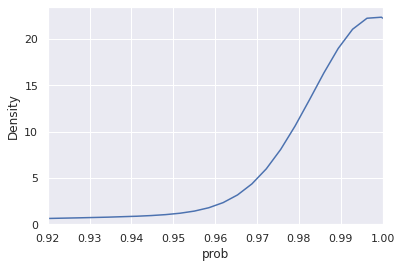

In [136]:
fig, ax = plt.subplots()
sns.distplot(df_negative["prob"], ax=ax, hist=False)
ax.set_xlim(0.92,1)
plt.show()

In [138]:
print(len(df_negative))
output = df_negative[df_negative["prob"] > 0.95]
print(len(output))

5712
5057


## similarity matching

In [60]:
from sentence_transformers import SentenceTransformer, util
import json

In [61]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [62]:
sent_1 = model.encode("hello")
sent_2 = model.encode("hi")

sim_scores = util.pytorch_cos_sim(sent_1, sent_2)
print(type(sim_scores.numpy()[0][0]))
print(sim_scores.numpy()[0][0])

<class 'numpy.float32'>
0.77275556


In [63]:
input_file = "data/b0013frnkg_third_person_positive_segments_testing_on_pool.tsv"

In [64]:
df = pd.read_csv(input_file, delimiter="\t")

In [65]:
len(df), df.columns

(12347, Index(['text', 'label', 'prob'], dtype='object'))

In [66]:
df.sort_values(by=["prob"], ascending=False, inplace=True, ignore_index=True)

In [67]:
len(df)

12347

In [68]:
pool_list = []
match_dict = {}
encoding_dict = {}

In [69]:
for index, row in df.iterrows():
    text = row["text"].lower().strip()
    text_encoding = model.encode([text])
    similar = False
    
    for loc in range(len(pool_list)):
        sim_score = util.pytorch_cos_sim(encoding_dict[loc], text_encoding).numpy()[0][0]
        
        if sim_score > 0.50:
            similar = True
            match_dict[loc].append((text, sim_score))
            break
            
    if not similar:
        pool_list.append(text)
        encoding_dict[len(pool_list)-1] = text_encoding
        match_dict[len(pool_list)-1] = []

In [70]:
len(pool_list)

733

In [71]:
count_dict = {}

for loc in range(len(pool_list)):
    num_of_sim_sent = len(match_dict[loc])
    
    if num_of_sim_sent not in count_dict:
        count_dict[num_of_sim_sent] = [loc]
    else:
        count_dict[num_of_sim_sent].append(loc)

In [ ]:
sorted(count_dict)

In [81]:
updated_pool_list = []

for key in count_dict.keys():
    if key > 10:
        for loc in count_dict[key]:
            updated_pool_list.append(pool_list[loc])

In [82]:
len(updated_pool_list)

140

In [44]:
pool_list

["like all of apple 's products , it delivers a really beautiful experience .",
 "so that 's a nice plus .",
 'recipient loves it !',
 'great product for a great price !',
 'amazing device , great for games , email , the web and the kids love it .',
 'and even the battery life is exceptional .',
 'got this ipad 3 stylus and a leather case for 590 something . totally worth it .',
 'what a great deal !',
 "it 's fun , attractive , and pretty funciontal .",
 'thank you for the smooth machine .',
 'perfect for the granddaughter .',
 'great for photos , music , ibooks , etc. .',
 'great for travel .',
 'bought for 80-yr old mom and she loves it .',
 'great to look up information fast and easy .',
 'app environment : really excellent variety and quality of applications for a broad range of uses and a broad range of prices .',
 'and save a good amount of money !',
 "this is one of the best `` gadgets ''",
 'great experience with the seller .',
 'really like it',
 'good for both work and play 

In [83]:
output_file_1 = "/home/saurabh/dir_1/shodh/Product-Comparison/qt/data/json/b0013frnkg_third_person_positive_segments_testing_on_pool_10_summ.json"

In [84]:
first_entity = {"entity_id": "b0013frnkg", "entity_name": "b0013frnkg_name", "reviews": []}

In [85]:
id_counter = 0
counter = 1

tmp_dict = {"review_id": str(id_counter), "sentences": []}

for segment in updated_pool_list:
    tmp_dict["sentences"].append(segment)
    
    if counter%5 == 0:
        first_entity["reviews"].append(tmp_dict)
        id_counter = id_counter + 1
        tmp_dict = {"review_id": str(id_counter), "sentences": []}
        
    counter = counter + 1
    

with open(output_file_1, "w") as out_f:
    out_f.write(json.dumps([first_entity]))

# Code to generate golden responses

In [142]:
import string

In [140]:
input_file_pos_1 = "data/gold/amazon_b0013frnkg_general_positive.txt"
input_file_neg_1 = "data/gold/amazon_b0013frnkg_general_negative.txt"
input_file_pos_2 = "data/gold/amazon_b00j8dl78o_general_positive.txt"
input_file_neg_2 = "data/gold/amazon_b00j8dl78o_general_negative.txt"

output_file = "data/gold/amazon_b0013frnkg_b00j8dl78o_general.txt"

In [145]:
pattern = "For {}, {}. However, some users have also mentioned that, {}."

In [147]:
name_1 = "Apple iPad 2"
name_2 = "Samsung Galaxy Tab 4"

In [159]:
punt = string.punctuation+" "+"\n\t"

pos_1_list = []
with open(input_file_pos_1, "r") as in_f:
    for line in in_f:
        striped_line = line.strip(punt)
        if len(striped_line) > 2:
            pos_1_list.append(striped_line)
        
neg_1_list = []
with open(input_file_neg_1, "r") as in_f:
    for line in in_f:
        striped_line = line.strip(punt)
        if len(striped_line) > 2:
            neg_1_list.append(striped_line)
        
pos_2_list = []
with open(input_file_pos_2, "r") as in_f:
    for line in in_f:
        striped_line = line.strip(punt)
        if len(striped_line) > 2:
            pos_2_list.append(striped_line)
        
neg_2_list = []
with open(input_file_neg_2, "r") as in_f:
    for line in in_f:
        striped_line = line.strip(punt)
        if len(striped_line) > 2:
            neg_2_list.append(striped_line)

In [160]:
print(len(pos_1_list))
print(len(neg_1_list))
print(len(pos_2_list))
print(len(neg_2_list))

17
19
21
18


In [161]:
output_list_1 = []
for pos_op in pos_1_list:
    for neg_op in neg_1_list:
        output_list_1.append(pattern.format(name_1, pos_op, neg_op))
        
print(len(output_list_1))

323


In [163]:
output_list_2 = []
for pos_op in pos_2_list:
    for neg_op in neg_2_list:
        output_list_2.append(pattern.format(name_2, pos_op, neg_op))
        
print(len(output_list_2))

378


In [164]:
for op in output_list_2:
    print(op)

For Samsung Galaxy Tab 4, best tablet. However, some users have also mentioned that, the warranty was voided.
For Samsung Galaxy Tab 4, best tablet. However, some users have also mentioned that, the audio is terribly broken.
For Samsung Galaxy Tab 4, best tablet. However, some users have also mentioned that, Samsung has the worst customer service.
For Samsung Galaxy Tab 4, best tablet. However, some users have also mentioned that, the first time was defective.
For Samsung Galaxy Tab 4, best tablet. However, some users have also mentioned that, There is a 2 second delay before the tablet fully loads the next setting tab.
For Samsung Galaxy Tab 4, best tablet. However, some users have also mentioned that, The biggest disappointment of all this Christmas.
For Samsung Galaxy Tab 4, best tablet. However, some users have also mentioned that, the touch-screen facility is at best terrible.
For Samsung Galaxy Tab 4, best tablet. However, some users have also mentioned that, has finally died.
Fo

In [165]:
output_list = []
for op_1 in output_list_1:
    for op_2 in output_list_2:
        output_list.append(op_1+"\n"+op_2)

In [166]:
output_list

['For Apple iPad 2, It runs apps very smooth. However, some users have also mentioned that, its awful.\nFor Samsung Galaxy Tab 4, best tablet. However, some users have also mentioned that, the warranty was voided.',
 'For Apple iPad 2, It runs apps very smooth. However, some users have also mentioned that, its awful.\nFor Samsung Galaxy Tab 4, best tablet. However, some users have also mentioned that, the audio is terribly broken.',
 'For Apple iPad 2, It runs apps very smooth. However, some users have also mentioned that, its awful.\nFor Samsung Galaxy Tab 4, best tablet. However, some users have also mentioned that, Samsung has the worst customer service.',
 'For Apple iPad 2, It runs apps very smooth. However, some users have also mentioned that, its awful.\nFor Samsung Galaxy Tab 4, best tablet. However, some users have also mentioned that, the first time was defective.',
 'For Apple iPad 2, It runs apps very smooth. However, some users have also mentioned that, its awful.\nFor Sam

In [167]:
with open(output_file, "w") as out_f:
    for op in output_list:
        out_f.write(op+"\n\n")

In [ ]:
##

In [168]:
## Golden responses for Battery

In [169]:
input_file_pos_1 = "data/gold/battery/amazon_b0013frnkg_battery_positive.txt"
input_file_neg_1 = "data/gold/battery/amazon_b0013frnkg_battery_negative.txt"
input_file_pos_2 = "data/gold/battery/amazon_b00j8dl78o_battery_positive.txt"
input_file_neg_2 = "data/gold/battery/amazon_b00j8dl78o_battery_negative.txt"

output_file = "data/gold/battery/amazon_b0013frnkg_b00j8dl78o_battery.txt"

In [178]:
pattern = "{} is shipped with {}. {}. However, some users have also mentioned that, {}."

In [179]:
name_1 = "Apple iPad 2"
name_2 = "Samsung Galaxy Tab 4"

battery_1 = "1 Lithium ion battery which can run up to 10 hours"
battery_2 = "3.8 Volt, 4000 mAh, 1 Lithium Metal batteries which can run up to 10 Hours"

In [180]:
punt = string.punctuation+" "+"\n\t"

pos_1_list = []
with open(input_file_pos_1, "r") as in_f:
    for line in in_f:
        striped_line = line.strip(punt)
        if len(striped_line) > 2:
            pos_1_list.append(striped_line)
        
neg_1_list = []
with open(input_file_neg_1, "r") as in_f:
    for line in in_f:
        striped_line = line.strip(punt)
        if len(striped_line) > 2:
            neg_1_list.append(striped_line)
        
pos_2_list = []
with open(input_file_pos_2, "r") as in_f:
    for line in in_f:
        striped_line = line.strip(punt)
        if len(striped_line) > 2:
            pos_2_list.append(striped_line)
        
neg_2_list = []
with open(input_file_neg_2, "r") as in_f:
    for line in in_f:
        striped_line = line.strip(punt)
        if len(striped_line) > 2:
            neg_2_list.append(striped_line)

In [181]:
print(len(pos_1_list))
print(len(neg_1_list))
print(len(pos_2_list))
print(len(neg_2_list))

18
18
20
21


In [182]:
output_list_1 = []
for pos_op in pos_1_list:
    for neg_op in neg_1_list:
        output_list_1.append(pattern.format(name_1, battery_1, pos_op, neg_op))
        
print(len(output_list_1))

324


In [183]:
output_list_2 = []
for pos_op in pos_2_list:
    for neg_op in neg_2_list:
        output_list_2.append(pattern.format(name_2, battery_2, pos_op, neg_op))
        
print(len(output_list_2))

420


In [184]:
for op in output_list_1:
    print(op)

Apple iPad 2 is shipped with 1 Lithium ion battery which can run up to 10 hours. provided extra battery life , extra ports and a hardware keyboard. However, some users have also mentioned that, the battery was dead.
Apple iPad 2 is shipped with 1 Lithium ion battery which can run up to 10 hours. provided extra battery life , extra ports and a hardware keyboard. However, some users have also mentioned that, the most significant of which was poor battery life and frequent crashes.
Apple iPad 2 is shipped with 1 Lithium ion battery which can run up to 10 hours. provided extra battery life , extra ports and a hardware keyboard. However, some users have also mentioned that, the battery life is pretty poor.
Apple iPad 2 is shipped with 1 Lithium ion battery which can run up to 10 hours. provided extra battery life , extra ports and a hardware keyboard. However, some users have also mentioned that, The battery did n't even make it 6 months before it stopped holding a charge.
Apple iPad 2 is s

In [185]:
for op in output_list_2:
    print(op)

Samsung Galaxy Tab 4 is shipped with 3.8 Volt, 4000 mAh, 1 Lithium Metal batteries which can run up to 10 Hours. its size , basic features , good battery life , and user interface. However, some users have also mentioned that, The battery port was scratched up.
Samsung Galaxy Tab 4 is shipped with 3.8 Volt, 4000 mAh, 1 Lithium Metal batteries which can run up to 10 Hours. its size , basic features , good battery life , and user interface. However, some users have also mentioned that, Too little internal storage , poor battery longevity/recharge time.
Samsung Galaxy Tab 4 is shipped with 3.8 Volt, 4000 mAh, 1 Lithium Metal batteries which can run up to 10 Hours. its size , basic features , good battery life , and user interface. However, some users have also mentioned that, Battery life is wimpy.
Samsung Galaxy Tab 4 is shipped with 3.8 Volt, 4000 mAh, 1 Lithium Metal batteries which can run up to 10 Hours. its size , basic features , good battery life , and user interface. However, som

In [186]:
output_list = []
for op_1 in output_list_1:
    for op_2 in output_list_2:
        output_list.append(op_1+"\n"+op_2)

In [187]:
with open(output_file, "w") as out_f:
    for op in output_list:
        out_f.write(op+"\n\n")

## Generate dataset for Semantically Driven Sentence Fusion

In [1]:
import pandas as pd
import json

In [6]:
input_file = "data/sentence_fusion/b00j8dl78o/battery/positive_general.txt"
output_file = "data/sentence_fusion/b00j8dl78o/battery/negative.jsonl"

In [7]:
df = pd.read_csv(input_file, delimiter='\t')

In [8]:
df.columns

Index(['input', 'no_modification', 'tense_anaphora', 'anaphora', 'tense'], dtype='object')

In [9]:
with open(output_file, "w") as out_f:
    for index, row in df.iterrows():
        tmp = {}
        tmp["input"] = row["input"]
        tmp["no_modification"] = row["no_modification"] if not pd.isna(row["no_modification"]) else None
        tmp["tense"] = row["tense"] if not pd.isna(row["tense"]) else None
        tmp["anaphora"] = row["anaphora"] if not pd.isna(row["anaphora"]) else None
        tmp["tense_anaphora"] = row["tense_anaphora"] if not pd.isna(row["tense_anaphora"]) else None
        
        out_f.write(json.dumps(tmp)+"\n")

# Generate dataset for Semantically Driven Sentence Fusion: generate responses

In [84]:
negative_opinion_file = "data/sentence_fusion/b0013frnkg/battery/negative.jsonl"
positive_opinion_file = "data/sentence_fusion/b0013frnkg/battery/positive.jsonl"
output_file = "data/sentence_fusion/b0013frnkg/battery/output.jsonl"

In [85]:
no_modification = "no_modification"
tense = "tense"
anaphora = "anaphora"
tense_anaphora = "tense_anaphora"


dm_1 = "discourse_marker_1"
dm_2 = "discourse_marker_2"
dp_1 = "discourse_phenomenon_1"
dp_2 = "discourse_phenomenon_2"

dp_pair = {}
dp_pair[no_modification] = "PAIR_CONN"
dp_pair[tense] = "PAIR_CONN_TENSE"
dp_pair[anaphora] = "PAIR_CONN_ANAPHORA"
dp_pair[tense_anaphora] = "PAIR_CONN_TENSE_ANAPHORA"

dp_single = {}
dp_single[no_modification] = "SINGLE_CONN"
dp_single[anaphora] = "SINGLE_CONN_ANAPHORA"
dp_single[tense] = "SINGLE_CONN_TENSE"
dp_single[tense_anaphora] = "SINGLE_CONN_TENSE_ANAPHORA"

dp_single_start = {}
dp_single_start[no_modification] = "SINGLE_CONN_START"
dp_single_start[tense] = "SINGLE_CONN_START_TENSE"
dp_single_start[anaphora] = "SINGLE_CONN_START_ANAPHORA"
dp_single_start[tense_anaphora] = "SINGLE_CONN_START_TENSE_ANAPHORA"

In [86]:
product_description = "Apple iPad 2 is shipped with 3.8 Volt, 4000 mAh, 1 Lithium Metal batteries which can run up to 10 Hours"

In [87]:
index_to_dm = {}
index_to_dm[0] = "However ,"
index_to_dm[1] = "Although ,"
index_to_dm[2] = "But"
index_to_dm[3] = "Yet ,"
index_to_dm[4] = ", although"
index_to_dm[5] = "however"
index_to_dm[6] = "although"
index_to_dm[7] = ", but"
index_to_dm[8] = "but"
index_to_dm[9] = ", yet"
index_to_dm[10] = "Although"
index_to_dm[11] = "NONE"

dm_to_index = {}
dm_to_index["However ,"] = 0
dm_to_index["Although ,"] = 1
dm_to_index["But"] = 2
dm_to_index["Yet ,"] = 3
dm_to_index[", although"] = 4
dm_to_index["however"] = 5
dm_to_index["although"] = 6
dm_to_index[", but"] = 7
dm_to_index["but"] = 8
dm_to_index[", yet"] = 9
dm_to_index["Although"] = 10
dm_to_index["NONE"] = 11

pair_pattern_dict = {}
single_pattern_dict = {}
single_start_pattern_dict = {}

pair_pattern_dict[0] = "{} . {} . However , some users have also mentioned that {} ."
pair_pattern_dict[1] = "{} . {} . Although , some users have also mentioned that {} ."
pair_pattern_dict[2] = "{} . {} . But some users have also mentioned that {} ."
pair_pattern_dict[3] = "{} . {} . Yet , some users have also mentioned that {} ."

single_pattern_dict[4] = "{} . {} , although some users have also mentioned that {} ."
single_pattern_dict[5] = "{} . {} however some users have also mentioned that {} ."
single_pattern_dict[6] = "{} . {} although some users have also mentioned that {} ."
single_pattern_dict[7] = "{} . {} , but some users have also mentioned that {} ."
single_pattern_dict[8] = "{} . {} but some users have also mentioned that {} ."
single_pattern_dict[9] = "{} . {} , yet some users have also mentioned that {} ."

single_start_pattern_dict[10] = "{} . Although {} , some users have also mentioned that {} ."

In [88]:
counter = 0
with open(output_file, "w") as out_f:
    with open(positive_opinion_file, "r") as pos_in_f:
            
        for pos_line in pos_in_f:
            pos_op_dict = json.loads(pos_line)
                
            with open(negative_opinion_file, "r") as neg_in_f:
                for neg_line in neg_in_f:
                    neg_op_dict = json.loads(neg_line)
                    
                    dataset_dict = {}
                    
                    tmp_input = {}
                    tmp_input["description"] = product_description
                    tmp_input["positive"] = pos_op_dict["input"]
                    tmp_input["negative"] = neg_op_dict["input"]
                    
                    dataset_dict["input"] = tmp_input

                    tmp_output_list = []
                    for pos_key in pos_op_dict.keys():
                        if pos_op_dict[pos_key] != None and pos_key != "input":
                            for neg_key in neg_op_dict.keys():
                                if neg_op_dict[neg_key] != None and neg_key != "input":
                                    
                                    for dm_key in pair_pattern_dict.keys():
                                        tmp_output = {}
                                        tmp_output["output"] = pair_pattern_dict[dm_key].format(product_description, 
                                                                                                pos_op_dict[pos_key],
                                                                                               neg_op_dict[neg_key])
                                        tmp_output[dm_1] = "NONE"
                                        tmp_output[dp_1] = dp_pair[pos_key]
                                        tmp_output[dm_2] = index_to_dm[dm_key]
                                        tmp_output[dp_2] = dp_pair[neg_key]
                                        tmp_output_list.append(tmp_output)
                                        counter += 1
                                        
                                    for dm_key in single_pattern_dict.keys():
                                        tmp_output = {}
                                        tmp_output["output"] = single_pattern_dict[dm_key].format(product_description, 
                                                                                                  pos_op_dict[pos_key],
                                                                                               neg_op_dict[neg_key])
                                        tmp_output[dm_1] = "NONE"
                                        tmp_output[dp_1] = dp_pair[pos_key]
                                        tmp_output[dm_2] = index_to_dm[dm_key]
                                        tmp_output[dp_2] = dp_single[neg_key]
                                        tmp_output_list.append(tmp_output)
                                        counter += 1

                                    for dm_key in single_start_pattern_dict.keys():
                                        tmp_output = {}
                                        tmp_output["output"] = single_start_pattern_dict[dm_key].format(product_description,
                                                                            pos_op_dict[pos_key], neg_op_dict[neg_key])
                                        tmp_output[dm_1] = index_to_dm[dm_key]
                                        tmp_output[dp_1] = dp_single_start[pos_key]
                                        tmp_output[dm_2] = "NONE"
                                        tmp_output[dp_2] = dp_single_start[neg_key]
                                        tmp_output_list.append(tmp_output)
                                        counter += 1

                    if len(tmp_output_list) > 0:                    
                        dataset_dict["outputs"] = tmp_output_list
                        out_f.write(json.dumps(dataset_dict)+"\n")

In [89]:
counter

5566

In [90]:
file_1 = "data/sentence_fusion/b0013frnkg/general/output.jsonl"
file_2 = "data/sentence_fusion/b0013frnkg/battery/output.jsonl"
file_3 = "data/sentence_fusion/b00j8dl78o/general/output.jsonl"
file_4 = "data/sentence_fusion/b00j8dl78o/battery/output.jsonl"

collate_output_file = "data/sentence_fusion/collate_output.jsonl"

In [92]:
with open(collate_output_file, "w") as out_f:
    with open(file_1, "r") as in_f1:
        for line in in_f1:
            out_f.write(line)
            
    with open(file_2, "r") as in_f2:
        for line in in_f2:
            out_f.write(line)
            
    with open(file_3, "r") as in_f3:
        for line in in_f3:
            out_f.write(line)
            
    with open(file_4, "r") as in_f4:
        for line in in_f4:
            out_f.write(line)

# Above code for v3_amazon dataset

In [97]:
import string, os, json

In [98]:
punt = string.punctuation+" "+"\n\t"

In [105]:
pos_input_dir = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/9_dataset_pos_neg_removed_invalid/pos"
neg_input_dir = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/9_dataset_pos_neg_removed_invalid/neg"
title_file = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/title.json"
output_dir = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/10_rule_based_dataset"

In [106]:
with open(title_file, "r") as title_f:
    for line in title_f:
        title_dict = json.loads(line)

In [107]:
pattern = "{} . {} . However , some users have also mentioned that {} ."

In [109]:
for file in os.listdir(pos_input_dir):
    title = title_dict[file.strip()]
    
    pos_opinion_list = []
    with open(os.path.join(pos_input_dir, file), "r") as pos_in_f:
        for line in pos_in_f:
            pos_opinion_list.append(line.strip(punt))
            
    neg_opinion_list = []
    with open(os.path.join(neg_input_dir, file), "r") as neg_in_f:
        for line in neg_in_f:
            neg_opinion_list.append(line.strip(punt))
            
    with open(os.path.join(output_dir, file.strip()), "w") as out_f:
        for pos_op in pos_opinion_list:
            for neg_op in neg_opinion_list:
                tmp_dict = {"title": title, "positive": pos_op, "negative": neg_op, 
                            "response": pattern.format(title, pos_op, neg_op)}
                out_f.write(json.dumps(tmp_dict)+"\n")

# Generating rule based output

In [334]:
pattern_list = ["{} . {} . However , some users have also mentioned that {} .",
                "{} . {} . Although , some users have also mentioned that {} .",
                "{} . {} . But some users have also mentioned that {} .",
                "{} . {} . Yet , some users have also mentioned that {} .",
                "{} . {} , although some users have also mentioned that {} .",
                "{} . {} however some users have also mentioned that {} .",
                "{} . {} although some users have also mentioned that {} .",
                "{} . {} , but some users have also mentioned that {} .",
                "{} . {} but some users have also mentioned that {} .",
                "{} . {} , yet some users have also mentioned that {} .",
                "{} . Although {} , some users have also mentioned that {} ."]

In [335]:
input_file = "data/sentence_fusion/uncase/test_uncase_preprocessed.jsonl"
output_file = "data/sentence_fusion/uncase/rule_based/rule_based_output.jsonl"

In [336]:
with open(output_file, "w") as out_f:
    with open(input_file, "r") as in_f:
        for line in in_f:
            obj_dict = json.loads(line)
            tmp_list = []
            ref_list = []
            
            for output in obj_dict["outputs"]:
                ref_list.append(output["output"].strip())
            
            for pattern in pattern_list:
                
                tmp_list.append(pattern.format(obj_dict["input"]["description"].strip(), obj_dict["input"]["positive"].strip(),
                                               obj_dict["input"]["negative"].strip()))
            
            input_ = "{} . {} . {}".format(obj_dict["input"]["description"].strip(), obj_dict["input"]["positive"].strip(), 
                                           obj_dict["input"]["negative"].strip())
            
            tmp_output = {"input": input_, 
                         "output": tmp_list,
                         "index": obj_dict["index"],
                         "reference": ref_list}
            
            out_f.write(json.dumps(tmp_output)+"\n")

# Split dataset into train, test and val sets

In [105]:
from sklearn.model_selection import train_test_split
import numpy as np

In [131]:
input_file = "data/sentence_fusion/b00j8dl78o/general/output.jsonl"
train_file = "data/sentence_fusion/b00j8dl78o/general/train.jsonl"
val_file = "data/sentence_fusion/b00j8dl78o/general/val.jsonl"
test_file = "data/sentence_fusion/b00j8dl78o/general/test.jsonl"

In [132]:
index_list = []
counter = 0

with open(input_file, "r") as in_f:
    for line in in_f:
        index_list.append(counter)
        counter += 1

In [133]:
train_data, test_val_data = train_test_split(np.array(index_list), test_size=0.3, train_size=0.7)

In [134]:
test_data, val_data = train_test_split(test_val_data, test_size=1/3, train_size=2/3)

In [135]:
train_f = open(train_file, "w")
val_f = open(val_file, "w")
test_f = open(test_file, "w")

In [136]:
counter = 0

with open(input_file, "r") as in_f:
    for line in in_f:
        if counter in train_data:
            train_f.write(line)
        elif counter in test_data:
            test_f.write(line)
        else:
            val_f.write(line)
            
        counter += 1

In [137]:
train_f.close()
val_f.close()
test_f.close()

In [138]:
train_file = "data/sentence_fusion/train.jsonl"
test_file = "data/sentence_fusion/test.jsonl"
val_file = "data/sentence_fusion/val.jsonl"

In [143]:
train_file_1 = "data/sentence_fusion/b00j8dl78o/general/test.jsonl"
train_file_2 = "data/sentence_fusion/b00j8dl78o/battery/test.jsonl"
train_file_3 = "data/sentence_fusion/b0013frnkg/general/test.jsonl"
train_file_4 = "data/sentence_fusion/b0013frnkg/battery/test.jsonl"

In [144]:
with open(test_file, "w") as train_f:
    with open(train_file_1, "r") as train_1_f:
        for line in train_1_f:
            train_f.write(line)
            
    with open(train_file_2, "r") as train_2_f:
        for line in train_2_f:
            train_f.write(line)
            
    with open(train_file_3, "r") as train_3_f:
        for line in train_3_f:
            train_f.write(line)
            
    with open(train_file_4, "r") as train_4_f:
        for line in train_4_f:
            train_f.write(line)

# Assign index to each dataset instance

In [145]:
import json

In [190]:
train_file = "data/sentence_fusion/train.jsonl"
test_file = "data/sentence_fusion/test.jsonl"
val_file = "data/sentence_fusion/val.jsonl"

In [191]:
train_uncase_file = "data/sentence_fusion/uncase/train_uncase.jsonl"
test_uncase_file = "data/sentence_fusion/uncase/test_uncase.jsonl"
val_uncase_file = "data/sentence_fusion/uncase/val_uncase.jsonl"

In [192]:
counter = 0

with open(train_file, "r") as in_f:
    with open(train_uncase_file, "w") as out_f:
        for line in in_f:
            dict_obj = json.loads(line)
            dict_obj["index"] = counter
            dict_obj["input"]["description"] = dict_obj["input"]["description"].lower()
            dict_obj["input"]["positive"] = dict_obj["input"]["positive"].lower()
            dict_obj["input"]["negative"] = dict_obj["input"]["negative"].lower()

            for output in dict_obj["outputs"]:
                output["output"] = output["output"].lower()
                output["discourse_marker_1"] = output["discourse_marker_1"].lower()
                output["discourse_marker_2"] = output["discourse_marker_2"].lower()

            out_f.write(json.dumps(dict_obj)+"\n")
            counter += 1
            
counter = 0

with open(test_file, "r") as in_f:
    with open(test_uncase_file, "w") as out_f:
        for line in in_f:
            dict_obj = json.loads(line)
            dict_obj["index"] = counter
            dict_obj["input"]["description"] = dict_obj["input"]["description"].lower()
            dict_obj["input"]["positive"] = dict_obj["input"]["positive"].lower()
            dict_obj["input"]["negative"] = dict_obj["input"]["negative"].lower()
      
            for output in dict_obj["outputs"]:
                output["output"] = output["output"].lower()
                output["discourse_marker_1"] = output["discourse_marker_1"].lower()
                output["discourse_marker_2"] = output["discourse_marker_2"].lower()

            out_f.write(json.dumps(dict_obj)+"\n")
            counter += 1
            
counter = 0

with open(val_file, "r") as in_f:
    with open(val_uncase_file, "w") as out_f:
        for line in in_f:
            dict_obj = json.loads(line)
            dict_obj["index"] = counter
            dict_obj["input"]["description"] = dict_obj["input"]["description"].lower()
            dict_obj["input"]["positive"] = dict_obj["input"]["positive"].lower()
            dict_obj["input"]["negative"] = dict_obj["input"]["negative"].lower()

            for output in dict_obj["outputs"]:
                output["output"] = output["output"].lower()
                output["discourse_marker_1"] = output["discourse_marker_1"].lower()
                output["discourse_marker_2"] = output["discourse_marker_2"].lower()

            out_f.write(json.dumps(dict_obj)+"\n")
            counter += 1

In [193]:
stat_dict = {}

with open(train_uncase_file, "r") as in_f:
    for line in in_f:
        obj_dict = json.loads(line)
        
        for output in obj_dict["outputs"]:
            if output["discourse_phenomenon_1"] in stat_dict:
                stat_dict[output["discourse_phenomenon_1"]] += 1
            else:
                stat_dict[output["discourse_phenomenon_1"]] = 0
                
            if output["discourse_phenomenon_2"] in stat_dict:
                stat_dict[output["discourse_phenomenon_2"]] += 1
            else:
                stat_dict[output["discourse_phenomenon_2"]] = 0

In [194]:
stat_dict

{'PAIR_CONN': 11675,
 'SINGLE_CONN': 4283,
 'SINGLE_CONN_START': 1595,
 'PAIR_CONN_TENSE_ANAPHORA': 3653,
 'SINGLE_CONN_START_TENSE_ANAPHORA': 512,
 'PAIR_CONN_TENSE': 2187,
 'SINGLE_CONN_TENSE': 1811,
 'SINGLE_CONN_START_TENSE': 399,
 'PAIR_CONN_ANAPHORA': 2571,
 'SINGLE_CONN_ANAPHORA': 1037,
 'SINGLE_CONN_START_ANAPHORA': 360,
 'SINGLE_CONN_TENSE_ANAPHORA': 1475}

In [195]:
stat_dict = {}

with open(test_uncase_file, "r") as in_f:
    for line in in_f:
        obj_dict = json.loads(line)
        
        for output in obj_dict["outputs"]:
            if output["discourse_phenomenon_1"] in stat_dict:
                stat_dict[output["discourse_phenomenon_1"]] += 1
            else:
                stat_dict[output["discourse_phenomenon_1"]] = 0
                
            if output["discourse_phenomenon_2"] in stat_dict:
                stat_dict[output["discourse_phenomenon_2"]] += 1
            else:
                stat_dict[output["discourse_phenomenon_2"]] = 0

In [196]:
stat_dict

{'PAIR_CONN': 3441,
 'PAIR_CONN_TENSE': 613,
 'SINGLE_CONN_TENSE': 605,
 'SINGLE_CONN_START': 462,
 'SINGLE_CONN_START_TENSE': 121,
 'PAIR_CONN_TENSE_ANAPHORA': 1065,
 'SINGLE_CONN_START_TENSE_ANAPHORA': 153,
 'SINGLE_CONN': 1187,
 'SINGLE_CONN_TENSE_ANAPHORA': 473,
 'PAIR_CONN_ANAPHORA': 827,
 'SINGLE_CONN_ANAPHORA': 281,
 'SINGLE_CONN_START_ANAPHORA': 110}

In [197]:
stat_dict = {}

with open(val_uncase_file, "r") as in_f:
    for line in in_f:
        obj_dict = json.loads(line)
        
        for output in obj_dict["outputs"]:
            if output["discourse_phenomenon_1"] in stat_dict:
                stat_dict[output["discourse_phenomenon_1"]] += 1
            else:
                stat_dict[output["discourse_phenomenon_1"]] = 0
                
            if output["discourse_phenomenon_2"] in stat_dict:
                stat_dict[output["discourse_phenomenon_2"]] += 1
            else:
                stat_dict[output["discourse_phenomenon_2"]] = 0

In [198]:
stat_dict

{'PAIR_CONN': 1701,
 'PAIR_CONN_TENSE': 329,
 'SINGLE_CONN_TENSE': 269,
 'SINGLE_CONN_START': 231,
 'SINGLE_CONN_START_TENSE': 59,
 'PAIR_CONN_TENSE_ANAPHORA': 595,
 'SINGLE_CONN_TENSE_ANAPHORA': 203,
 'SINGLE_CONN_START_TENSE_ANAPHORA': 79,
 'SINGLE_CONN': 617,
 'PAIR_CONN_ANAPHORA': 381,
 'SINGLE_CONN_ANAPHORA': 197,
 'SINGLE_CONN_START_ANAPHORA': 57}

# Preprocess string, separating punctuation from words.

In [238]:
import json

In [242]:
def pre_process(utterance):
    for char in ['-', '.', ',', "'", "$", "&", "#", "/", "+", "_", ":", "@"]:
        utterance = utterance.replace("{} ".format(char), " {} ".format(char)).replace(" {}".format(char), " {} ".format(char))

    return utterance

In [243]:
input_file = "data/sentence_fusion/uncase/rule_based/rule_based_output.jsonl"
output_file = "data/sentence_fusion/uncase/rule_based/rule_based_output_preprocessed.jsonl"

In [245]:
with open(output_file, "w") as out_f:
    with open(input_file, "r") as in_f:
        for line in in_f:
            dict_obj = json.loads(line)
            dict_obj["input"] = pre_process(dict_obj["input"])
            
            output_list = []
            for output in dict_obj["output"]:
                output_list.append(pre_process(output))
            
            dict_obj["output"] = output_list
                
            ref_list = []
            for ref in dict_obj["reference"]:
                ref_list.append(pre_process(ref))
                
            dict_obj["reference"] = ref_list
            
            out_f.write(json.dumps(dict_obj)+"\n")

# Found a bug in the datset. 'outputs' is empty for few instances. Fixing bug. 

In [309]:
import json

In [331]:
input_file = "data/sentence_fusion/uncase/val_uncase.jsonl"
output_file = "data/sentence_fusion/uncase/val_uncase_preprocessed.jsonl"

In [332]:
def pre_process(utterance):
    for char in ['-', '.', ',', "'", "$", "&", "#", "/", "+", "_", ":", "@"]:
        utterance = utterance.replace("{} ".format(char), " {} ".format(char)).replace(" {}".format(char), " {} ".format(char))
    
    utterance = utterance.strip()
    return " ".join(utterance.split())

In [333]:
with open(output_file, "w") as out_f:
    with open(input_file, "r") as in_f:
        for line in in_f:
            dict_obj = json.loads(line)
            
            if len(dict_obj["outputs"]) > 0:
                dict_obj["input"]["description"] = pre_process(dict_obj["input"]["description"])
                dict_obj["input"]["positive"] = pre_process(dict_obj["input"]["positive"])
                dict_obj["input"]["negative"] = pre_process(dict_obj["input"]["negative"])
                
                for output in dict_obj["outputs"]:
                    output["output"] = pre_process(output["output"])
                    
                out_f.write(json.dumps(dict_obj)+"\n")

# Evaluation methods

# Multi Reference Exact Match

In [181]:
import json

In [81]:
def mr_exact(input_list, output_list, ref_list, output_file, stat_file):
    """
        input_list: list of strings
        output_list: list of strings
        ref_list: list of lists of strings
    """
    
    exact = 0
    total = 0
    
    match_instances = []
    
    with open(output_file, "w") as out_f:
        for index in range(len(input_list)):
            if output_list[index] in ref_list[index]:
                exact += 1
                out_f.write(json.dumps({"input": input_list[index], "output": output_list[index],
                                        "ref": ref_list[index]}) + "\n")

            total += 1
            
    with open(stat_file, "w") as out_f:
        out_f.write(json.dumps({"exact": exact, "total": total}))

In [82]:
# input_file = "data/sentence_fusion/uncase/rule_based/rule_based_output.jsonl"
# output_file = "data/sentence_fusion/uncase/rule_based/exact/exact_match.jsonl"
# stat_file = "data/sentence_fusion/uncase/rule_based/exact/exact_stat.jsonl"

input_file = "data/sentence_fusion/uncase/bart_translation/eval_version_2.jsonl"
output_file = "data/sentence_fusion/uncase/bart_translation/eval_output_version_2.jsonl"
stat_file = "data/sentence_fusion/uncase/bart_translation/eval_stats_version_2.jsonl"

In [83]:
input_list = []
output_list = []
ref_list = []

In [84]:
# with open(input_file, "r") as in_f:
#     for line in in_f:
#         dict_obj = json.loads(line)
        
#         for output in dict_obj["output"]:
#             input_list.append(dict_obj["input"])
#             output_list.append(output)
#             ref_list.append(dict_obj["reference"])

with open(input_file, "r") as in_f:
    for line in in_f:
        dict_obj = json.loads(line)
        
        input_list.append(dict_obj["input"])
        output_list.append(dict_obj["output"])
        ref_list.append(dict_obj["reference"])

In [85]:
len(ref_list)

219

In [86]:
mr_exact(input_list, output_list, ref_list, output_file, stat_file)

In [207]:
1 == [1, 2]

False

# SARI Metrics

In [343]:
from sari_utils import *

In [344]:
input_file = "data/sentence_fusion/uncase/rule_based/rule_based_output.jsonl"

In [345]:
input_list = []
output_list = []
ref_list = []

In [346]:
with open(input_file, "r") as in_f:
    for line in in_f:
        dict_obj = json.loads(line)
        
        ref_token_list = []
        for ref in dict_obj["reference"]:
            ref_token_list.append(ref.split())
        
        for output in dict_obj["output"]:
            input_list.append(dict_obj["input"].split())
            output_list.append(output.split())
            ref_list.append(ref_token_list)

In [347]:
get_sari_score(input_list, output_list, ref_list)

TypeError: unhashable type: 'list'

# This code works when I run program via terminal. I am not able to understand why it is giving error when I run it in Jupyter. Output at terminal: 
{'sari': 0.6502856526714712, 'keep_score': 0.9262367188578472, 'addition_score': 0.42356906741776484, 'deletion_score': 0.6010511717388015}

# BLEU evaluation metrics

In [114]:
from nltk.translate.bleu_score import corpus_bleu

In [115]:
# input_file = "data/sentence_fusion/uncase/rule_based/rule_based_output.jsonl"
# output_file = "data/sentence_fusion/uncase/rule_based/corpus_bleu/stats.jsonl"

input_file = "data/sentence_fusion/uncase/bart_translation/eval_version_2.jsonl"
stat_file = "data/sentence_fusion/uncase/bart_translation/bleu/stats.jsonl"

In [116]:
input_list = []
output_list = []
ref_list = []

In [117]:
# with open(input_file, "r") as in_f:
#     for line in in_f:
#         dict_obj = json.loads(line)
        
#         ref_token_list = []
#         for ref in dict_obj["reference"]:
#             ref_token_list.append(ref.split())
        
#         for output in dict_obj["output"]:
#             input_list.append(dict_obj["input"].split())
#             output_list.append(output.split())
#             ref_list.append(ref_token_list)

with open(input_file, "r") as in_f:
    for line in in_f:
        dict_obj = json.loads(line)
        
        input_list.append(dict_obj["input"])
        output_list.append(dict_obj["output"])
        ref_list.append(dict_obj["reference"])

In [118]:
output = corpus_bleu(list_of_references=ref_list, hypotheses=output_list)

In [119]:
with open(stat_file, "w") as out_f:
    out_f.write(json.dumps({"corpus_bleu": output}))

In [120]:
output

0.9273298079459572

# Rouge evaluation metric

In [121]:
import rouge
import json

In [122]:
# input_file = "data/sentence_fusion/uncase/rule_based/rule_based_output.jsonl"
# output_file = "data/sentence_fusion/uncase/rule_based/rouge/stats.jsonl"

input_file = "data/sentence_fusion/uncase/bart_translation/eval_version_2.jsonl"
stat_file = "data/sentence_fusion/uncase/bart_translation/rouge/stats.jsonl"

In [123]:
output_list = []
ref_list = []

In [124]:
# with open(input_file, "r") as in_f:
#     for line in in_f:
#         dict_obj = json.loads(line)
        
#         for output in dict_obj["output"]:
#             output_list.append(output)
#             ref_list.append(dict_obj["reference"])

with open(input_file, "r") as in_f:
    for line in in_f:
        dict_obj = json.loads(line)
        
#         input_list.append(dict_obj["input"])
        output_list.append(dict_obj["output"])
        ref_list.append(dict_obj["reference"])

In [131]:
   evaluator = rouge.Rouge(metrics=['rouge-n', 'rouge-l', 'rouge-w'],
                           max_n=4,
                           limit_length=True,
                           length_limit=300,
                           length_limit_type='words',
                           apply_avg=False,
                           apply_best=True,
                           alpha=0.5, # Default F1_score
                           weight_factor=1.2,
                           stemming=True)

In [132]:
scores = evaluator.get_scores(output_list, ref_list)

In [130]:
scores #avg

{'rouge-3': {'f': 0.8436320698762005,
  'p': 0.8826919107904938,
  'r': 0.8130594636197225},
 'rouge-1': {'f': 0.9315513754818175,
  'p': 0.9727893376570323,
  'r': 0.8987976795179548},
 'rouge-2': {'f': 0.8882673056202572,
  'p': 0.9285270002766407,
  'r': 0.856521083767198},
 'rouge-4': {'f': 0.7995797761714071,
  'p': 0.8373762568538895,
  'r': 0.7702323048900042},
 'rouge-l': {'f': 0.9403312604445836,
  'p': 0.9747772003675775,
  'r': 0.9119107614943365},
 'rouge-w': {'f': 0.5376971110584801,
  'p': 0.8768055116851984,
  'r': 0.3891195964335752}}

In [133]:
scores #best

{'rouge-3': {'f': 0.9131173339361751,
  'p': 0.952259758197863,
  'r': 0.8822060643798101},
 'rouge-1': {'f': 0.9517915954257848,
  'p': 0.9899068615656246,
  'r': 0.9218725647000673},
 'rouge-2': {'f': 0.9342019626169716,
  'p': 0.9740066612762182,
  'r': 0.9025418102396966},
 'rouge-4': {'f': 0.8927222106837268,
  'p': 0.9311223628365088,
  'r': 0.8626244401758822},
 'rouge-l': {'f': 0.9578664149570412,
  'p': 0.989657725014395,
  'r': 0.9318872292908066},
 'rouge-w': {'f': 0.5831265723358872,
  'p': 0.9427755282843363,
  'r': 0.4236618695835258}}

In [135]:
avg_score = {'rouge-3': {'f': 0.8436320698762005,
  'p': 0.8826919107904938,
  'r': 0.8130594636197225},
 'rouge-1': {'f': 0.9315513754818175,
  'p': 0.9727893376570323,
  'r': 0.8987976795179548},
 'rouge-2': {'f': 0.8882673056202572,
  'p': 0.9285270002766407,
  'r': 0.856521083767198},
 'rouge-4': {'f': 0.7995797761714071,
  'p': 0.8373762568538895,
  'r': 0.7702323048900042},
 'rouge-l': {'f': 0.9403312604445836,
  'p': 0.9747772003675775,
  'r': 0.9119107614943365},
 'rouge-w': {'f': 0.5376971110584801,
  'p': 0.8768055116851984,
  'r': 0.3891195964335752}}

best_score = {'rouge-3': {'f': 0.9131173339361751,
  'p': 0.952259758197863,
  'r': 0.8822060643798101},
 'rouge-1': {'f': 0.9517915954257848,
  'p': 0.9899068615656246,
  'r': 0.9218725647000673},
 'rouge-2': {'f': 0.9342019626169716,
  'p': 0.9740066612762182,
  'r': 0.9025418102396966},
 'rouge-4': {'f': 0.8927222106837268,
  'p': 0.9311223628365088,
  'r': 0.8626244401758822},
 'rouge-l': {'f': 0.9578664149570412,
  'p': 0.989657725014395,
  'r': 0.9318872292908066},
 'rouge-w': {'f': 0.5831265723358872,
  'p': 0.9427755282843363,
  'r': 0.4236618695835258}}

dict_ = {"avg": avg_score, "best": best_score}

In [136]:
with open(stat_file, "w") as out_f:
    out_f.write(json.dumps(dict_))

# Generating dataset for BART based translation

In [40]:
import json

In [41]:
input_file = "data/sentence_fusion/uncase/train_version_1.jsonl"
output_file = "data/sentence_fusion/uncase/bart_translation/train_version_1.jsonl"

In [42]:
with open(output_file, "w") as out_f:
    with open(input_file, "r") as in_f:
        for line in in_f:
            obj_dict = json.loads(line)
            
            defused_sent = "{} . {} . {} .".format(obj_dict["input"]["description"], obj_dict["input"]["positive"], 
                                                  obj_dict["input"]["negative"])
            
            for output in obj_dict["outputs"]:
                tmp_dict = {"translation" : {}}
                tmp_dict["translation"]["defused"] = defused_sent
                tmp_dict["translation"]["fused"] = output["output"]
                
                out_f.write(json.dumps(tmp_dict)+"\n")

TypeError: string indices must be integers

# Appending train and validation file

In [4]:
import json

In [7]:
train_file = "data/sentence_fusion/uncase/train_uncase_preprocessed.jsonl"
val_file = "data/sentence_fusion/uncase/val_uncase_preprocessed.jsonl"
output_file = "data/sentence_fusion/uncase/train_val_uncase_preprocessed.jsonl"

In [8]:
index_counter = 0

In [9]:
with open(output_file, "w") as out_f:
    for file in [train_file, val_file]:
        with open(file, "r") as in_f:
            for line in in_f:
                obj_dict = json.loads(line)
                obj_dict["index"] = index_counter
                index_counter += 1
                out_f.write(json.dumps(obj_dict)+"\n")

# Generating dataset in new version for BART based translation

In [12]:
import json

In [28]:
input_file = "data/sentence_fusion/uncase/train_val_uncase_preprocessed.jsonl"
test_file = "data/sentence_fusion/uncase/test_uncase_preprocessed.jsonl"
output_file = "data/sentence_fusion/uncase/train_version_2.jsonl"

In [29]:
index_to_sent_dict = {}
discourse_count_dict = {}

In [30]:
with open(input_file, "r") as in_f:
    for line in in_f:
        dict_obj = json.loads(line)
        
        for output in dict_obj["outputs"]:
            key_ = (output["discourse_marker_1"], output["discourse_phenomenon_1"], 
                                     output["discourse_marker_2"], output["discourse_phenomenon_2"])
            
            if discourse_count_dict.get(key_, None) == None:
                discourse_count_dict[key_] = [dict_obj["index"]]
            else:
                discourse_count_dict[key_].append(dict_obj["index"])
                
            if index_to_sent_dict.get(dict_obj["index"], None) == None:
                index_to_sent_dict[dict_obj["index"]] = {key_: {"input": dict_obj["input"], "output": output}}
            else:
                index_to_sent_dict[dict_obj["index"]][key_] = {"input": dict_obj["input"], "output": output}

In [31]:
len(discourse_count_dict)

176

In [32]:
for key in discourse_count_dict.keys():
    print(len(discourse_count_dict[key]))

495
495
495
495
495
495
495
495
495
495
495
159
159
159
159
159
159
159
159
159
159
159
215
215
215
215
215
215
215
215
215
215
215
64
64
64
64
64
64
64
64
64
64
64
128
128
128
128
128
128
128
128
128
128
128
36
36
36
36
36
36
36
36
36
36
36
173
173
173
173
173
173
173
173
173
173
173
54
54
54
54
54
54
54
54
54
54
54
22
22
22
22
22
22
22
22
22
22
22
60
60
60
60
60
60
60
60
60
60
60
10
10
10
10
10
10
10
10
10
10
10
21
21
21
21
21
21
21
21
21
21
21
46
46
46
46
46
46
46
46
46
46
46
103
103
103
103
103
103
103
103
103
103
103
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32


In [33]:
len(index_to_sent_dict)

870

In [34]:
sorted_discourse_count_dict = dict(sorted(discourse_count_dict.items(), key= lambda x: len(x[1])))

In [35]:
for key in sorted_discourse_count_dict.keys():
    print(len(sorted_discourse_count_dict[key]))

10
10
10
10
10
10
10
10
10
10
10
21
21
21
21
21
21
21
21
21
21
21
22
22
22
22
22
22
22
22
22
22
22
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
36
36
36
36
36
36
36
36
36
36
36
46
46
46
46
46
46
46
46
46
46
46
54
54
54
54
54
54
54
54
54
54
54
60
60
60
60
60
60
60
60
60
60
60
64
64
64
64
64
64
64
64
64
64
64
103
103
103
103
103
103
103
103
103
103
103
128
128
128
128
128
128
128
128
128
128
128
159
159
159
159
159
159
159
159
159
159
159
173
173
173
173
173
173
173
173
173
173
173
215
215
215
215
215
215
215
215
215
215
215
495
495
495
495
495
495
495
495
495
495
495


In [36]:
found = True

with open(output_file, "w") as out_f:
    while found:
        found = False
        for key in sorted_discourse_count_dict.keys():
            ignore_list = []
            
            for index in sorted_discourse_count_dict[key]:
                if index_to_sent_dict[index] != None:
                    out_f.write(json.dumps(index_to_sent_dict[index][key])+"\n")
                    index_to_sent_dict[index] = None
                    ignore_list.append(index)
                    found = True
                    break
                else:
                    ignore_list.append(index)
                    
            if len(ignore_list) > 0:
                for index in ignore_list:
                    sorted_discourse_count_dict[key].remove(index)      

In [37]:
input_file = "data/sentence_fusion/uncase/train_version_2.jsonl"
output_file = "data/sentence_fusion/uncase/bart_translation/train_version_2.jsonl"

In [38]:
with open(output_file, "w") as out_f:
    with open(input_file, "r") as in_f:
        for line in in_f:
            obj_dict = json.loads(line)
            
            defused_sent = "{} . {} . {} .".format(obj_dict["input"]["description"], obj_dict["input"]["positive"], 
                                                  obj_dict["input"]["negative"])
            tmp_dict = {"translation" : {}}
            tmp_dict["translation"]["defused"] = defused_sent
            tmp_dict["translation"]["fused"] = obj_dict["output"]["output"]

            out_f.write(json.dumps(tmp_dict)+"\n")

In [41]:
for key, value in index_to_sent_dict.items():
    if value is not None:
            print(key)

# Generating test dataset in new format for BART

In [44]:
input_file = "data/sentence_fusion/uncase/test_uncase_preprocessed.jsonl"
output_file = "data/sentence_fusion/uncase/bart_translation/test_version_2.jsonl"

In [45]:
with open(output_file, "w") as out_f:
    with open(input_file, "r") as in_f:
        for line in in_f:
            obj_dict = json.loads(line)
            
            defused_sent = "{} . {} . {} .".format(obj_dict["input"]["description"], obj_dict["input"]["positive"], 
                                                  obj_dict["input"]["negative"])
            tmp_dict = {"translation" : {}}
            tmp_dict["translation"]["defused"] = defused_sent
            tmp_dict["translation"]["fused"] = obj_dict["outputs"][0]["output"]

            out_f.write(json.dumps(tmp_dict)+"\n")

# Generate output file for evaluation containing model output and reference output.

In [70]:
import json
import nltk

In [104]:
output_file = "data/sentence_fusion/uncase/bart_translation/output_version_2.txt"
ref_file = "data/sentence_fusion/uncase/test_uncase_preprocessed.jsonl"
input_file = "data/sentence_fusion/uncase/bart_translation/test_version_2.json"
eval_file = "data/sentence_fusion/uncase/bart_translation/eval_version_2.jsonl"

In [105]:
with open(eval_file, "w") as eval_f:
    with open(output_file, "r") as out_f:
        with open(ref_file, "r") as ref_f:
            with open(input_file, "r") as in_f:
                for out_l, ref_l, in_l in zip(out_f, ref_f, in_f):
                    tmp_dict = {}

                    in_obj = json.loads(in_l)
                    tmp_dict["input"] = in_obj["translation"]["defused"].strip()

                    tmp_dict["output"] = " ".join(nltk.word_tokenize(out_l.strip()))

                    ref_obj = json.loads(ref_l)
                    ref_list = []

                    for output in ref_obj["outputs"]:
                        ref_list.append(output["output"].strip())
                    tmp_dict["reference"] = ref_list                
                    
                    eval_f.write(json.dumps(tmp_dict)+"\n")

# Proposed method for sentence fusion

# Dataset generation

In [2]:
import json

In [12]:
input_file = "data/sentence_fusion/uncase/train_version_2.jsonl"
output_file = "data/sentence_fusion/uncase/proposed_approach/train_version_2.jsonl"

In [13]:
discourse_marker_dict = {}
discourse_type_dict = {}
discourse_marker_counter = 0
discourse_type_counter = 0

In [14]:
with open(output_file, "w") as out_f:
    with open(input_file, "r") as in_f:
        for line in in_f:
            obj = json.loads(line)
            
            tmp_dict = {}
            tmp_dict["input_text_1"] = obj["input"]["description"] + " . " + obj["input"]["positive"]
            tmp_dict["input_text_2"] = obj["input"]["positive"] + " . " + obj["input"]["negative"]
            tmp_dict["output"] = obj["output"]["output"]
                        
            if obj["output"]["discourse_phenomenon_1"] not in discourse_type_dict:
                discourse_type_dict[obj["output"]["discourse_phenomenon_1"]] = discourse_type_counter
                discourse_type_counter += 1

            if obj["output"]["discourse_phenomenon_2"] not in discourse_type_dict:
                discourse_type_dict[obj["output"]["discourse_phenomenon_2"]] = discourse_type_counter
                discourse_type_counter += 1
                
            tmp_dict["discourse_type_1"] = discourse_type_dict[obj["output"]["discourse_phenomenon_1"]]
            tmp_dict["discourse_type_2"] = discourse_type_dict[obj["output"]["discourse_phenomenon_2"]]
            
            if obj["output"]["discourse_marker_1"] not in discourse_marker_dict:
                discourse_marker_dict[obj["output"]["discourse_marker_1"]] = discourse_marker_counter
                discourse_marker_counter += 1

            if obj["output"]["discourse_marker_2"] not in discourse_marker_dict:
                discourse_marker_dict[obj["output"]["discourse_marker_2"]] = discourse_marker_counter
                discourse_marker_counter += 1

            tmp_dict["discourse_marker_1"] = discourse_marker_dict[obj["output"]["discourse_marker_1"]]
            tmp_dict["discourse_marker_2"] = discourse_marker_dict[obj["output"]["discourse_marker_2"]]

            out_f.write(json.dumps(tmp_dict) + "\n")

In [18]:
discourse_type_dict

{'PAIR_CONN_TENSE': 0,
 'PAIR_CONN_ANAPHORA': 1,
 'SINGLE_CONN_ANAPHORA': 2,
 'PAIR_CONN_TENSE_ANAPHORA': 3,
 'SINGLE_CONN_TENSE_ANAPHORA': 4,
 'SINGLE_CONN_START_TENSE': 5,
 'SINGLE_CONN_START_TENSE_ANAPHORA': 6,
 'SINGLE_CONN_TENSE': 7,
 'SINGLE_CONN_START_ANAPHORA': 8,
 'PAIR_CONN': 9,
 'SINGLE_CONN': 10,
 'SINGLE_CONN_START': 11}

In [19]:
discourse_marker_dict

{'none': 0,
 'however ,': 1,
 'although ,': 2,
 'but': 3,
 'yet ,': 4,
 ', although': 5,
 'however': 6,
 'although': 7,
 ', but': 8,
 ', yet': 9}

In [17]:
config_file = "data/sentence_fusion/uncase/proposed_approach/config.jsonl"

In [20]:
with open(config_file, "w") as config_f:
    config_f.write(json.dumps({"discourse_type": discourse_type_dict, "discourse_marker": discourse_marker_dict}))

# Train dataset generation from v3_data

In [110]:
import os, json

In [113]:
input_dir = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/10_rule_based_dataset"
output_dir = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/11_rule_based_dataset"
train_file = "data_v3.jsonl"

In [115]:
with open(os.path.join(output_dir, train_file), "w") as out_f:
    for file in os.listdir(input_dir):
        with open(os.path.join(input_dir, file), "r") as in_f:
            for line in in_f:
                data_dict = json.loads(line)
                tmp_dict = {}
                tmp_dict["input_text_1"] = data_dict["title"] + " . " + data_dict["positive"]
                tmp_dict["input_text_2"] = data_dict["positive"] + " . " + data_dict["negative"]
                tmp_dict["discourse_type_1"] = 0
                tmp_dict["discourse_type_2"] = 1
                tmp_dict["output"] = data_dict["response"]
                out_f.write(json.dumps(tmp_dict)+"\n")

# Converting dataset into train and test split

In [127]:
from sklearn.model_selection import train_test_split
import numpy as np


In [130]:
# input_file = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/11_rule_based_dataset/data_v3.jsonl"
# train_file = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/12_rule_based_dataset/train_v3.jsonl"
# test_file = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/12_rule_based_dataset/test_v3.jsonl"
input_file = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/11_rule_based_dataset/data_v3.jsonl"
train_file = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/12_rule_based_dataset/train_v3_50_percent.jsonl"
test_file = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/12_rule_based_dataset/test_v3_50_percent.jsonl"

In [131]:
index_list = []
counter = 0

with open(input_file, "r") as in_f:
    for line in in_f:
        index_list.append(counter)
        counter += 1
        
train_data, test_val_data = train_test_split(np.array(index_list), test_size=0.5, train_size=0.5)
train_50, test_50 = train_test_split(train_data, test_size=0.1, train_size=0.9)

In [135]:
"number of train instances: {}, number of test instances: {}".format(len(train_50), len(test_50))

'number of train instances: 46596, number of test instances: 5178'

In [137]:
counter = 0

with open(train_file, "w") as train_f:
    with open(test_file, "w") as test_f:
        with open(input_file, "r") as in_f:
            for line in in_f:
                if counter in train_50:
                    train_f.write(line)
                elif counter in test_50:
                    test_f.write(line)
                counter += 1

# Test dataset generation

In [9]:
import json

In [10]:
input_file = "data/sentence_fusion/uncase/test_uncase_preprocessed.jsonl"
output_file = "data/sentence_fusion/uncase/proposed_approach/test_version_2.jsonl"
config_file = "data/sentence_fusion/uncase/proposed_approach/config.jsonl"

In [11]:
with open(config_file, "r") as in_f:
    for line in in_f:
        config_dict = json.loads(line)

In [12]:
with open(output_file, "w") as out_f:
    with open(input_file, "r") as in_f:
        for line in in_f:
            obj = json.loads(line)
            
            tmp_dict = {}
            tmp_dict["input_text_1"] = obj["input"]["description"] + " . " + obj["input"]["positive"]
            tmp_dict["input_text_2"] = obj["input"]["positive"] + " . " + obj["input"]["negative"]
            tmp_dict["output"] = obj["outputs"][0]["output"]

            tmp_dict["discourse_type_1"] = config_dict["discourse_type"][obj["outputs"][0]["discourse_phenomenon_1"]]
            tmp_dict["discourse_type_2"] = config_dict["discourse_type"][obj["outputs"][0]["discourse_phenomenon_2"]]

            tmp_dict["discourse_marker_1"] = config_dict["discourse_marker"][obj["outputs"][0]["discourse_marker_1"]]
            tmp_dict["discourse_marker_2"] = config_dict["discourse_marker"][obj["outputs"][0]["discourse_marker_2"]]

            out_f.write(json.dumps(tmp_dict) + "\n")

# Semantic Similarity variable name experiment

In [1]:
name = "bert/pooler/dense/bias:0"

In [2]:
import re

In [3]:
m = re.match("^(.*):\\d+$", name)

if m is not None:
    print(m.group(1))

bert/pooler/dense/bias


# Resolving name issue while loading pre-trained weights for sentence fusion task

In [2]:
var_name = "bert/pooler/dense_1_1/kernel"

if "bert/pooler/dense_1_1" in var_name:
    updated_var_name = var_name.replace("dense_1_1", "dense_1")

In [4]:
updated_var_name

'bert/pooler/dense_1/kernel'

In [5]:
var_name

'bert/pooler/dense_1_1/kernel'

# Sentence fusion output unicode to text

In [6]:
import json, sys

import texar


#from examples.bert.utils import tokenization

ModuleNotFoundError: No module named 'texar'

In [2]:
input_file = "/home/saurabh/dir_1/shodh/SentenceFusion/models/AuxBert/amazon/prediction_output.jsonl"
output_file = "/home/saurabh/dir_1/shodh/SentenceFusion/models/AuxBert/amazon/prediction_output_text.jsonl"
vocab_file = "uncased_L-12_H-768_A-12/vocab.txt"

In [3]:
tokenizer = tokenization.FullTokenizer(vocab_file=vocab_file, do_lower_case=True)

NameError: name 'tokenization' is not defined

In [ ]:
with open(output_file, "w") as out_f:
    with open(input_file, "r") as in_f:
        for line in in_f:
            obj_dict = json.loads(line)
            
            for i in range(len(obj_dict['hypothesis'])):
                tmp_dict = {}
                tmp_dict["hypothesis"] = tokenizer.convert_ids_to_tokens(obj_dict['hypothesis'][i])
                tmp_dict["reference"] = tokenizer.convert_ids_to_tokens(obj_dict['references'][i])
                
                out_f.write(json.dumps(tmp_dict) + "\n")

# Tensorboard summary

In [4]:
%load_ext tensorboard

In [5]:
%tensorboard --logdir "/home/saurabh/dir_1/shodh/SentenceFusion/models/AuxBert/amazon/"

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

# Train dataset exploration for proposed approach

In [7]:
import json

In [8]:
input_file = "/home/saurabh/dir_1/shodh/Product-Comparison/data/sentence_fusion/uncase/proposed_approach/train_version_2.jsonl"

In [17]:
config_dict = {}
with open(input_file, "r") as in_f:
    for line in in_f:
        dict_obj = json.loads(line)
        for key in dict_obj.keys():
            if key in config_dict:
                if dict_obj[key] in config_dict[key]:
                    config_dict[key][dict_obj[key]] += 1
                else:
                    config_dict[key][dict_obj[key]] = 1
            else:
                config_dict[key] = {dict_obj[key]: 1}
                
del config_dict["input_text_1"]
del config_dict["input_text_2"]
del config_dict["output"]

In [18]:
config_dict

{'discourse_type_1': {0: 77,
  5: 5,
  1: 137,
  8: 12,
  3: 192,
  6: 18,
  9: 392,
  11: 37},
 'discourse_type_2': {1: 58,
  2: 80,
  3: 70,
  4: 96,
  6: 15,
  0: 72,
  7: 100,
  5: 16,
  8: 11,
  9: 134,
  10: 188,
  11: 30},
 'discourse_marker_1': {0: 798, 7: 72},
 'discourse_marker_2': {1: 86,
  2: 84,
  3: 156,
  4: 82,
  5: 81,
  6: 81,
  7: 79,
  8: 76,
  9: 73,
  0: 72}}

# V3 dataset creation

In [1]:
"""
In V3 I keep only one discourse marker, i.e. however.
I have included more dataset.
"""

'\nIn V3 I keep only one discourse marker, i.e. however.\nI have included more dataset.\n'

# Generate input dataset for EDUs 

In [9]:
import os, json

In [10]:
input_dir = "/home/saurabh/dir_1/reviews_summarization/dataset"
output_dir = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/raw_dataset"

In [11]:
for file_name in os.listdir(input_dir):
    input_file = os.path.join(input_dir, file_name)
    output_file = os.path.join(output_dir, file_name.split(".")[0]+".txt")
    
    with open(input_file, "r") as in_f:
        with open(output_file, "w") as out_f:
            for line in in_f:
                review = json.loads(line)["review"].strip()
                if len(review.split()) > 2 and "</a>" not in review and "</div>" not in review and "<input" not in review:
                    out_f.write(review+"\n\n")

# Script to execute EDU program inside docker

In [15]:
import os

In [16]:
input_dir = "/opt/feng-hirst-rst-parser/texts/raw_dataset"
output_dir = "/opt/feng-hirst-rst-parser/texts/raw_dataset_output"

In [17]:
for file_name in os.listdir(input_dir):
    input_file = os.path.join(input_dir, file_name)
    cmd = "python parse.py {} --skip_parsing --output_dir {}".format(input_file, output_dir)
    os.system(cmd)

FileNotFoundError: [Errno 2] No such file or directory: '/opt/feng-hirst-rst-parser/texts/raw_dataset'

In [1]:
list_ = [1, 2, 3, 4, 5]

for key, val in list_.items():
    print(key)
    print(val)

AttributeError: 'list' object has no attribute 'items'

# Extracting title from asin

In [11]:
import os, json

In [16]:
input_dir = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/segment_polarity_4"
input_file = "/data/saurabh/filtered_meta_Electronics.json"
output_file = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/title.json"

In [5]:
asin_set = set()

for file in os.listdir(input_dir):
    asin_set.add(file.split(".", maxsplit=1)[0].strip())

In [12]:
title_dict = {}

In [13]:
with open(input_file, "r") as in_f:
    for line in in_f:
        tmp_dict = json.loads(line)
        
        if tmp_dict["asin"].lower().strip() in asin_set:
            title_dict[tmp_dict["asin"].lower().strip()] = tmp_dict["title"]

In [17]:
with open(output_file, "w") as out_f:
    out_f.write(json.dumps(title_dict))

# Computes perplexity of a sentence

In [3]:
import sys
import numpy as np
 
import torch
from transformers import BertTokenizer,BertForMaskedLM
# Load pre-trained model (weights)
with torch.no_grad():
    model = BertForMaskedLM.from_pretrained('bert-base-uncased')
    model.eval()
    # Load pre-trained model tokenizer (vocabulary)
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# def score(sentence):
#     tokenize_input = tokenizer.tokenize(sentence)
#     tokenize_input = ["[CLS]"]+tokenize_input+["[SEP]"]
    
#     tensor_input = torch.tensor([tokenizer.convert_tokens_to_ids(tokenize_input)])
    
#     with torch.no_grad():
#         loss=model(tensor_input)[0]
    
#     return np.exp(loss.detach().numpy())

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
output = get_score("this product does not")

AttributeError: 'MaskedLMOutput' object has no attribute 'squeeze'

In [9]:
def get_score(sentence):
    tokenize_input = tokenizer.tokenize(sentence)
    tensor_input = torch.tensor([tokenizer.convert_tokens_to_ids(tokenize_input)])
    predictions=model(tensor_input)
    loss_fct = torch.nn.CrossEntropyLoss()
    loss = loss_fct(predictions.squeeze(), tensor_input.squeeze()).data 
    return math.exp(loss)

In [23]:
sentence = "this product does not"

tokenize_input = tokenizer.tokenize(sentence)
tensor_input = torch.tensor([tokenizer.convert_tokens_to_ids(tokenize_input)])
predictions = model(tensor_input, tensor_input)


In [24]:
predictions

MaskedLMOutput(loss=None, logits=tensor([[[-12.6557, -12.5422, -12.5032,  ..., -10.9540,  -9.2345, -10.8326],
         [-13.0594, -12.9534, -12.9172,  ..., -11.3452,  -9.6921, -11.1639],
         [-12.8771, -12.7727, -12.7424,  ..., -11.1825,  -9.5238, -11.2488],
         [-12.6930, -12.5664, -12.5137,  ..., -11.0174,  -9.2706, -10.9725]]],
       grad_fn=<AddBackward0>), hidden_states=None, attentions=None)

# Code to detect incomplete sentences

In [26]:
import spacy
from spacy.symbols import PRON, PROPN, NOUN, AUX, VERB

In [28]:
!python -m spacy download en_core_web_sm


     |████████████████████████████████| 13.6 MB 13.0 MB/s eta 0:00:01    |▋                               | 276 kB 13.0 MB/s eta 0:00:02     |█████████████████████▏          | 9.0 MB 13.0 MB/s eta 0:00:01
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.1.0
    Uninstalling en-core-web-sm-2.1.0:
      Successfully uninstalled en-core-web-sm-2.1.0
You should consider upgrading via the '/home/saurabh/venvs/general_env/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [29]:
nlp = spacy.load("en_core_web_sm")

In [44]:
doc = nlp("the resolution is horrible")

In [45]:
noun_list = [NOUN, PRON, PROPN]
verb_list = [AUX, VERB]

In [46]:
is_noun = False
is_verb = False

for token in doc:
    if token.pos in noun_list:
        is_noun = True
    elif token.pos in verb_list:
        is_verb = True

In [47]:
if is_noun and is_verb:
    print("valid")
else:
    print("invalid")

valid


# Code to detect first word and its output summary

In [53]:
import spacy, os

In [70]:
input_dir = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/8_qt_summary/positive/amazon_v3_removed_invalid"
output_dir = ""

In [71]:
nlp = spacy.load("en_core_web_sm")
tuple_set = set()
tuple_sent_set = set()

In [72]:
for file in os.listdir(input_dir):
    with open(os.path.join(input_dir, file), "r") as in_f:
        for line in in_f:
            doc = nlp(line.strip())
            token = list(doc)[0]
            tuple_token = (token.text, token.pos_)
            
            if tuple_token not in tuple_set:
                tuple_set.add((token.text, token.pos_))
                tuple_sent_set.add((token.text, token.pos_, line.strip()))

In [73]:
tuple_sent_set

{('&', 'CCONJ', '& the battery life is wonderful .'),
 ("'", 'PUNCT', "' is the perfect size ."),
 ('--', 'PUNCT', "-- you wo n't be disappointed ."),
 ('a', 'DET', 'a great thing to have'),
 ('absolutely', 'ADV', 'absolutely love it !!'),
 ('added',
  'VERB',
  'added 240gb sandisk ssd plus hard drive and 8gb more of memory - well worth'),
 ('again', 'ADV', "again it 's worth"),
 ('all', 'DET', 'all the hardware works'),
 ('also', 'ADV', 'also , the webcam is amazing'),
 ('alternating',
  'VERB',
  'alternating between finger taps and a rocketfish stylus has worked out well .'),
 ('amazon', 'NOUN', 'amazon is amazing .'),
 ('and', 'CCONJ', 'and love it .'),
 ('android', 'NOUN', 'android is good .'),
 ('another', 'DET', 'another pleasant aspect is'),
 ('anyhow', 'ADV', 'anyhow , this tablet is great'),
 ('anyways',
  'ADV',
  'anyways , everything is great about it other than that .'),
 ('appealing', 'VERB', 'appealing with an ipad .'),
 ('apple', 'NOUN', 'apple is genius'),
 ('applica

In [74]:
first_token_list = ["because", "and", "before", "but", "however", "now", "of", "then", "&", "or"]

# Code to remove first word found in above analysis

In [77]:
import spacy, os

In [90]:
# input_dir = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/8_qt_summary/positive/amazon_v3_removed_invalid"
input_dir = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/8_qt_summary/negative/amazon_v3_removed_invalid"
# output_dir = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/9_dataset_pos_neg_removed_invalid/pos"
output_dir = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/9_dataset_pos_neg_removed_invalid/neg"

In [91]:
nlp = spacy.load("en_core_web_sm")
first_token_list = ["because", "and", "before", "but", "however", "now", "of", "then", "&", "or"]

In [92]:
for file in os.listdir(input_dir):
    entity_id = file.split("_")[-1]
    with open(os.path.join(output_dir, entity_id), "w") as out_f:
        with open(os.path.join(input_dir, file), "r") as in_f:
            for line in in_f:
                line = line.strip()
                doc_list = list(nlp(line))
                
                if doc_list[0].text in first_token_list:
                    tmp_list = []
                    for token in doc_list[1:]:
                        tmp_list.append(token.text)
                    
                    line = " ".join(tmp_list)

                out_f.write(line+"\n")

# Encoder Decoder Based approach

# Training dataset generation

In [8]:
import json, os

In [9]:
input_dir = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/10_rule_based_dataset"
output_dir = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/13_transformer_encoder_decoder"
train_file = "data_v3.jsonl"

In [10]:
with open(os.path.join(output_dir, train_file), "w") as out_f:
    for file in os.listdir(input_dir):
        with open(os.path.join(input_dir, file), "r") as in_f:
            for line in in_f:
                data_dict = json.loads(line)
                tmp_dict = {}
                tmp_dict["input"] = data_dict["title"] + " . " + data_dict["positive"] + " . " + data_dict["negative"] + " ."
                tmp_dict["output"] = data_dict["response"]
                out_f.write(json.dumps(tmp_dict)+"\n")

# Generate train test and eval dataset

In [11]:
from sklearn.model_selection import train_test_split
import numpy as np

In [12]:
input_file = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/13_transformer_encoder_decoder/data_v3.jsonl"
train_file = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/13_transformer_encoder_decoder/train.jsonl"
test_file = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/13_transformer_encoder_decoder/test.jsonl"
val_file = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/13_transformer_encoder_decoder/val.jsonl"

In [13]:
index_list = []
counter = 0

with open(input_file, "r") as in_f:
    for line in in_f:
        index_list.append(counter)
        counter += 1
        
train_data, test_val_data = train_test_split(np.array(index_list), test_size=0.3, train_size=0.7)
test_data, val_data = train_test_split(test_val_data, test_size=1/3, train_size=2/3)

print("train size: {}, test size: {}, val size: {}".format(len(train_data), len(test_data), len(val_data)))

counter = 0

with open(train_file, "w") as train_f:
    with open(test_file, "w") as test_f:
        with open(val_file, "w") as val_f: 
            with open(input_file, "r") as in_f:
                for line in in_f:
                    if counter in train_data:
                        train_f.write(line)
                    elif counter in test_data:
                        test_f.write(line)
                    elif counter in val_data:
                        val_f.write(line)
                    
                    counter += 1

train size: 72484, test size: 20710, val size: 10355


# Dataset creation for Encoder Decoder model

In [3]:
from transformers import BertTokenizer, EncoderDecoderModel, Seq2SeqTrainer, Seq2SeqTrainingArguments, RobertaTokenizer, GPT2Tokenizer
import json, torch, wandb, os, random
import numpy as np

In [4]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: saurabhhssaurabh (use `wandb login --relogin` to force relogin)


True

In [5]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [6]:
%env WANDB_PROJECT="comparitive_response_generation"

env: WANDB_PROJECT="comparitive_response_generation"


In [7]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [8]:
train_file = "/home/saurabh/dir_1/shodh/Product-Comparison/data/sentence_fusion/uncase/bart_translation/train_version_2.json"
test_file = "/home/saurabh/dir_1/shodh/Product-Comparison/data/sentence_fusion/uncase/bart_translation/test_version_2.json"


# train_file = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/13_transformer_encoder_decoder/train.jsonl"
# val_file = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/13_transformer_encoder_decoder/val.jsonl"
# test_file = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/13_transformer_encoder_decoder/test.jsonl"

In [7]:
train_input = []
train_output = []

with open(train_file, "r") as in_f:
    for line in in_f:
        tmp_dict = json.loads(line)
        train_input.append(tmp_dict["translation"]["defused"])
        train_output.append(tmp_dict["translation"]["fused"])

#         train_input.append(tmp_dict["input"])
#         train_output.append(tmp_dict["output"])
        
print("len(train_input): {}, len(train_output): {}".format(len(train_input), len(train_output)))

len(train_input): 870, len(train_output): 870


In [28]:
test_input = []
test_output = []

with open(test_file, "r") as in_f:
    for line in in_f:
        tmp_dict = json.loads(line)
        test_input.append(tmp_dict["translation"]["defused"])
        test_output.append(tmp_dict["translation"]["fused"])

#         test_input.append(tmp_dict["input"])
#         test_output.append(tmp_dict["output"])
        
print("len(test_input): {}, len(test_output): {}".format(len(test_input), len(test_output)))

len(test_input): 219, len(test_output): 219


In [126]:
val_input = []
val_output = []

with open(val_file, "r") as in_f:
    for line in in_f:
        tmp_dict = json.loads(line)
        val_input.append(tmp_dict["input"])
        val_output.append(tmp_dict["output"])
        
print("len(val_input): {}, len(val_output): {}".format(len(val_input), len(val_output)))

len(val_input): 10355, len(val_output): 10355


In [9]:
train_input_encoding_list = tokenizer(train_input, truncation=True, padding=True)
train_output_encoding_list = tokenizer(train_output, truncation=True, padding=True)
# test_input_encoding_list = tokenizer(test_input, truncation=True, padding=True)
# test_output_encoding_list = tokenizer(test_output, truncation=True, padding=True)
# val_input_encoding_list = tokenizer(val_input, truncation=True, padding=True)
# val_output_encoding_list = gpt2_tokenizer(val_output, truncation=True, padding=True)

In [14]:
class ComparativeResponseDataset(torch.utils.data.Dataset):
    
    def __init__(self, input_encoding, output_encoding):
        self.input_encoding = input_encoding
        self.output_encoding = output_encoding
        
    def __getitem__(self, index):
        item = {}
        item["input_ids"] = np.array(self.input_encoding.input_ids[index])
        item["attention_mask"] = np.array(self.input_encoding.attention_mask[index])
        item["token_type_ids"] = np.array(self.input_encoding.token_type_ids[index])
        item["decoder_input_ids"] = np.array(self.output_encoding.input_ids[index])
        item["decoder_attention_mask"] = np.array(self.output_encoding.attention_mask[index])
        item["decoder_token_type_ids"] = np.array(self.output_encoding.token_type_ids[index])
        item["labels"] = []
        
        for token in self.output_encoding.input_ids[index]:
            if token == tokenizer.pad_token_id:
                item["labels"].append(-100)
            else:
                item["labels"].append(token)
                
        item["labels"] = np.array(item["labels"])
                
        return item
    
    def __len__(self):
        return len(self.input_encoding.input_ids)

In [11]:
train_dataset = ComparativeResponseDataset(train_input_encoding_list, train_output_encoding_list)
# test_dataset = ComparativeResponseDataset(test_input_encoding_list, test_output_encoding_list)
# val_dataset = ComparativeResponseDataset(val_input_encoding_list, val_output_encoding_list)

In [12]:
model = EncoderDecoderModel.from_encoder_decoder_pretrained("bert-base-uncased", "bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.bias', 'cls.seq_relations

In [13]:
training_args = Seq2SeqTrainingArguments(
    output_dir = "/home/saurabh/dir_1/shodh/Product-Comparison/models/transformer_bert_2_bert_multi_ref_870/output",
    do_train = True,
    do_eval = True,
    evaluation_strategy = "epoch",
    per_device_train_batch_size = 64,
    per_device_eval_batch_size = 64,
    num_train_epochs = 5,
    logging_dir = "/home/saurabh/dir_1/shodh/Product-Comparison/models/transformer_bert_2_bert_multi_ref_870/logs",
    logging_strategy = "epoch",
    save_strategy = "epoch",
    save_total_limit = 2,
    run_name = "transformer_bert_2_bert_multi_ref_870",
    report_to="wandb")




# parallel_mode ParallelMode.NOT_DISTRIBUTED
# train_batch_size 8
# eval_batch_size 8

torch.cuda.device_count(): 1


In [16]:
trainer = Seq2SeqTrainer(model=model, tokenizer=tokenizer, train_dataset=train_dataset, args=training_args, eval_dataset=train_dataset)

In [18]:
trainer.train()

***** Running training *****
  Num examples = 870
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 70


Epoch,Training Loss,Validation Loss
1,0.690900,0.357572
2,0.551700,0.307365
3,0.527300,0.307365
4,0.519400,0.307365
5,0.520900,0.307365


***** Running Evaluation *****
  Num examples = 870
  Batch size = 64
Saving model checkpoint to /home/saurabh/dir_1/shodh/Product-Comparison/models/transformer_bert_2_bert_multi_ref_870/output/checkpoint-14
Configuration saved in /home/saurabh/dir_1/shodh/Product-Comparison/models/transformer_bert_2_bert_multi_ref_870/output/checkpoint-14/config.json
Model weights saved in /home/saurabh/dir_1/shodh/Product-Comparison/models/transformer_bert_2_bert_multi_ref_870/output/checkpoint-14/pytorch_model.bin
tokenizer config file saved in /home/saurabh/dir_1/shodh/Product-Comparison/models/transformer_bert_2_bert_multi_ref_870/output/checkpoint-14/tokenizer_config.json
Special tokens file saved in /home/saurabh/dir_1/shodh/Product-Comparison/models/transformer_bert_2_bert_multi_ref_870/output/checkpoint-14/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 870
  Batch size = 64
Saving model checkpoint to /home/saurabh/dir_1/shodh/Product-Comparison/models/transformer_bert_

TrainOutput(global_step=70, training_loss=0.5620476382119315, metrics={'train_runtime': 94.7305, 'train_samples_per_second': 45.92, 'train_steps_per_second': 0.739, 'total_flos': 802642386546000.0, 'train_loss': 0.5620476382119315, 'epoch': 5.0})

In [19]:
wandb.finish()

eval/loss,█▄▂▁▁▁▁▁
eval/runtime,▁▃▄▁▃▄▆█
eval/samples_per_second,█▆▅█▆▅▃▁
eval/steps_per_second,█▆▅█▆▅▃▁
train/epoch,▁▁▁▃▃▅▅▁▁▃▃▅▅▆▆███
train/global_step,▁▁▁▃▃▅▅▁▁▃▃▅▅▆▆███
train/learning_rate,██▆▅▃▁▁▁▁
train/loss,█▄▂▂▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


# Predicting on fine-tuned model

In [29]:
model_dir = "/home/saurabh/dir_1/shodh/Product-Comparison/models/transformer_bert_2_bert_multi_ref_870/output/checkpoint-70"
# model_dir = "/home/saurabh/dir_1/shodh/Product-Comparison/models/transformer_encoder_decoder/transformer_encoder_decoder/output/checkpoint-3399"

In [30]:
# elem_list = [i for i in range(20000)]
# random.shuffle(elem_list)
# selected = elem_list[:200]

selected_test_input = test_input #[test_input[i] for i in selected]
selected_test_output = test_output #[test_output[i] for i in selected]

In [31]:
test_input_encoding_list = tokenizer(selected_test_input, truncation=True, padding=True)
test_output_encoding_list = tokenizer(selected_test_output, truncation=True, padding=True)

In [34]:
len(test_output_encoding_list["input_ids"])

219

In [35]:
test_dataset = ComparativeResponseDataset(test_input_encoding_list, test_output_encoding_list)

In [36]:
len(test_dataset)

219

In [37]:
model_for_pred = EncoderDecoderModel.from_pretrained(model_dir)

loading configuration file /home/saurabh/dir_1/shodh/Product-Comparison/models/transformer_bert_2_bert_multi_ref_870/output/checkpoint-70/config.json
Model config EncoderDecoderConfig {
  "architectures": [
    "EncoderDecoderModel"
  ],
  "decoder": {
    "_name_or_path": "bert-base-uncased",
    "add_cross_attention": true,
    "architectures": [
      "BertForMaskedLM"
    ],
    "attention_probs_dropout_prob": 0.1,
    "bad_words_ids": null,
    "bos_token_id": null,
    "chunk_size_feed_forward": 0,
    "classifier_dropout": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "gradient_checkpointing": false,
    "hidden_act": "gelu",
    "hidden_dropout_prob": 0.1,
    "hidden_size": 768,
    "id2label": {
      "0": "LABEL_0",
      "1": "LABEL_1"

In [38]:
training_args_for_pred = Seq2SeqTrainingArguments(
    output_dir = "/home/saurabh/dir_1/shodh/Product-Comparison/models/transformer_bert_2_bert_multi_ref_870/output",
    do_train = False,
    do_eval = False,
    do_predict = True,
#     eval_accumulation_steps=20,
    run_name = "transformer_bert_2_bert_multi_ref_870",
    report_to="wandb")

PyTorch: setting up devices


torch.cuda.device_count(): 1


In [39]:
trainer_for_pred = Seq2SeqTrainer(model=model_for_pred, tokenizer=tokenizer, args=training_args_for_pred)

In [40]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=20, shuffle=False)
output = trainer_for_pred.prediction_loop(test_loader, description="description")

***** Running description *****
  Num examples = 219
  Batch size = 20
/home/saurabh/venvs/general_env/lib/python3.6/site-packages/transformers/trainer_pt_utils.py:378: FutureWarning: DistributedTensorGatherer is deprecated and will be removed in v5 of Transformers.
  FutureWarning,


In [41]:
prediction_output = output.predictions[0].argmax(axis=-1)
prediction_output.shape

(219, 89)

In [45]:
def id_to_text(input_ids, output_ids, prediction_ids, tokenizer):
    tmp_dict = {}
    tmp_dict["input"] = tokenizer.decode(input_ids, skip_special_tokens=True)
    index_array = np.where(input_ids == 102)[0]
    if len(index_array) > 0:
        input_ids = input_ids[:index_array[0]]

#     tmp_dict["input_ids"] = input_ids[1:].tolist()
    
    index_array = np.where(output_ids == -100)[0]
    if len(index_array) > 0:
        output_ids = output_ids[:index_array[0]]
        
    index_array = np.where(prediction_ids == 102)[0]
    if len(index_array) > 0:
        prediction_ids = prediction_ids[:index_array[0]]

    tmp_dict["gt_output"] = tokenizer.decode(output_ids, skip_special_tokens=True)
#     tmp_dict["gt_output_ids"] = output_ids[1:-1].tolist()
    tmp_dict["prediction_output"] = tokenizer.decode(prediction_ids, skip_special_tokens=True)
#     tmp_dict["prediction_output_ids"] = prediction_ids.tolist()
    return tmp_dict

In [46]:
output_stat_file = "/home/saurabh/dir_1/shodh/Product-Comparison/models/transformer_bert_2_bert_multi_ref_870/output/output_bert_bert_multi_870.jsonl"

In [47]:
with open(output_stat_file, "w") as out_f:
    for index in range(len(prediction_output)):
        input_ids = test_dataset[index]["input_ids"]
        output_ids = test_dataset[index]["labels"]
        prediction_ids = prediction_output[index]

        tmp_dict = id_to_text(input_ids, output_ids, prediction_ids, tokenizer)
        out_f.write(json.dumps(tmp_dict)+"\n")

In [232]:
file_name = "/home/saurabh/dir_1/shodh/Product-Comparison/data/v3_dataset/13_transformer_encoder_decoder/output_bert_bert_200.jsonl"

In [48]:
input_list = []
pred_list = []
ref_list = []

input_id_list = []
pred_id_list = []
ref_id_list = []

with open(output_stat_file, "r") as in_f:
    for line in in_f:
        tmp_dict = json.loads(line)
        input_list.append(tmp_dict["input"])
#         input_id_list.append(tmp_dict["input_ids"])
        pred_list.append(tmp_dict["prediction_output"])
#         pred_id_list.append(tmp_dict["prediction_output_ids"])
        ref_list.append([tmp_dict["gt_output"]])
#         ref_id_list.append([tmp_dict["gt_output_ids"]])

In [49]:
assert len(input_list) == len(pred_list) == len(ref_list)

In [50]:
import datasets

In [51]:
sari_metric = datasets.load_metric("sari")

In [52]:
output_score = sari_metric.compute(sources=input_list, predictions=pred_list, references=ref_list)

In [53]:
output_score

{'sari': 54.871759800169585}

In [241]:
from evaluation.sari_hook import get_sari_score

In [245]:
sari_list = []
keep_list = []
addition_list = []
deletion_list = []

In [246]:
for i in range(len(input_id_list)):
    output = get_sari_score(source_ids=input_id_list[i], prediction_ids=pred_id_list[i], list_of_targets=ref_id_list[i])
    sari_list.append(output[0])
    keep_list.append(output[1])
    addition_list.append(output[2])
    deletion_list.append(output[3])

In [247]:
sum(sari_list)/len(sari_list)

1.0

In [248]:
np.mean(sari_list)

1.0